# We're going to try modelling the SLFV as a GP, adding in discrete periods onto the mean model. While it's not a perfect match for the PSD function we used to fit the periodograms, we're going to try following Pereira et al. (2019, https://arxiv.org/abs/1908.10662) and use the stochastically-driven, damped harmonic oscillator.

In [1]:
import numpy as np
import pandas as pd
from TESStools import *
import os
import warnings
from multiprocessing import Pool, cpu_count
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import h5py as h5

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
from pymc3_ext.utils import eval_in_model
import arviz as az

import exoplanet

print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


In [2]:
from aesara_theano_fallback import __version__ as tt_version
from celerite2 import __version__ as c2_version
pm.__version__, pmx.__version__, tt_version, c2_version

('3.11.4', '0.1.0', '0.0.4', '0.2.0')

In [3]:
cool_sgs = pd.read_csv('sample.csv',index_col=0)
cool_sgs

,RA,Dec,dist,pmRA,pmDec,Tmag,ContRatio,SpT,CommonName,MKType,...,SpecSource,Gal,w1mag,w2mag,w3mag,w4mag,RA_tic,Dec_tic,source_id,n_sectors
tic,,,,,,,,,,,,,,,,,,,,,
179437520,79.971947,-68.067692,0.091019,1.593040,0.205590,9.8540,NaN,RSG,SV* HV 2450,M1,...,N,LMC,6.841,6.993,6.134,4.754,79.971929,-68.067717,4658722752228316160,12
404965649,85.373961,-69.415872,0.060785,1.788260,0.708052,11.0373,NaN,RSG,CPD-69 502,NaN,...,N,LMC,8.013,8.161,7.247,5.391,85.374008,-69.415869,4657625263503324544,11
40185978,76.968537,-70.434641,0.160504,2.140400,0.216068,11.1070,NaN,RSG,SK -70 80,M0,...,N,LMC,8.254,8.398,8.099,7.782,76.968487,-70.434600,4652070290243179776,12
181445828,13.765720,-73.010260,0.236534,0.797799,-1.265550,11.0965,NaN,YSG,PMMR 74,G6Ia-Iab,...,N,SMC,8.741,8.825,8.492,8.396,NaN,NaN,4685961808462981248,1
182735393,15.655494,-72.273615,0.085619,0.942084,-1.163470,11.1242,NaN,YSG,PMMR 135,G6.5Ia-Iab,...,N,SMC,8.807,8.863,8.588,8.536,NaN,NaN,4687498998758427520,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182730317,16.205624,-72.106040,0.055346,0.664882,-1.272430,11.4480,NaN,YSG,RMC 36,B3:Iak,...,N,SMC,11.204,11.192,11.061,9.228,NaN,NaN,4687507584364583040,1
180792170,12.659946,-73.471738,0.058121,0.543531,-1.243180,11.1544,NaN,YSG,HD 5045,B2:I:,...,N,SMC,10.896,10.853,10.681,9.225,NaN,NaN,4685876050900042880,2
182905190,16.484663,-72.329100,0.057287,0.986675,-1.257930,11.6057,NaN,YSG,LHA 115-S 45,B1.5Ia:,...,N,SMC,11.192,11.145,10.694,7.014,NaN,NaN,4687488965713758336,2


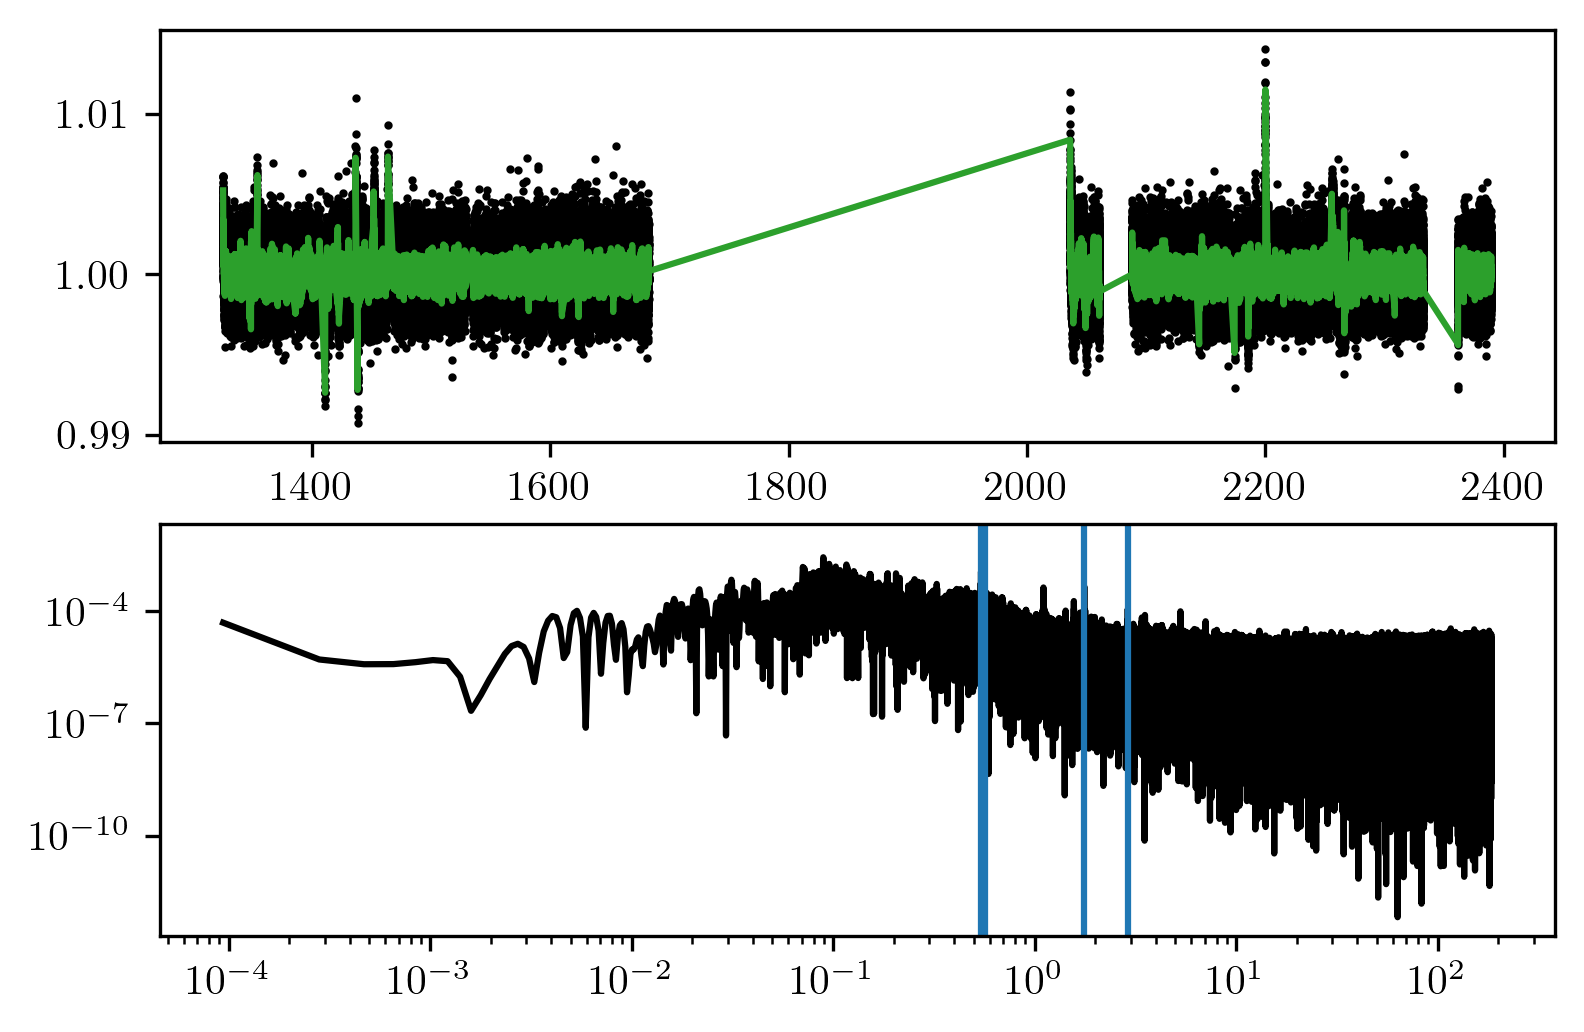

In [4]:
example = cool_sgs[cool_sgs['CommonName']=='HD 269110']
tic = example.index[0]
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth='30T')

time, flux, err = lc['Time'].values, lc['Flux'].values, lc['Err'].values
time_s, flux_s, err_s = lc_smooth['Time'].values, lc_smooth['Flux'].values, lc_smooth['Err'].values

pseudo_NF = 0.5 / (np.mean(np.diff(time)))

ls = LombScargle(time,flux,dy=err,)
freq,power=ls.autopower(normalization='psd',maximum_frequency=pseudo_NF)
power /= len(time)

ls_s = LombScargle(time_s,flux_s,dy=err_s,)
freq_s,power_s=ls_s.autopower(normalization='psd',maximum_frequency=pseudo_NF)
power_s /= len(time_s)

fig, ax = plt.subplots(2, 1, dpi=300)

ax[0].scatter(time, flux,s=1,c='k')
ax[0].plot(time_s, flux_s,c='C2')

ax[1].loglog(freq, power, c='k')

with h5.File('prewhitening.hdf5','r') as pw:
    good_fs = pw[f'{tic}/good_fs'][()]
    good_amps = pw[f'{tic}/good_amps'][()]
    good_phases = pw[f'{tic}/good_phases'][()]
good_fs
for f in good_fs[:,0]:
    ax[1].axvline(f)
#ax[1].loglog(freq_s, power_s, c='C2')

In [5]:
len(time), len(time_s)

(392906, 392906)

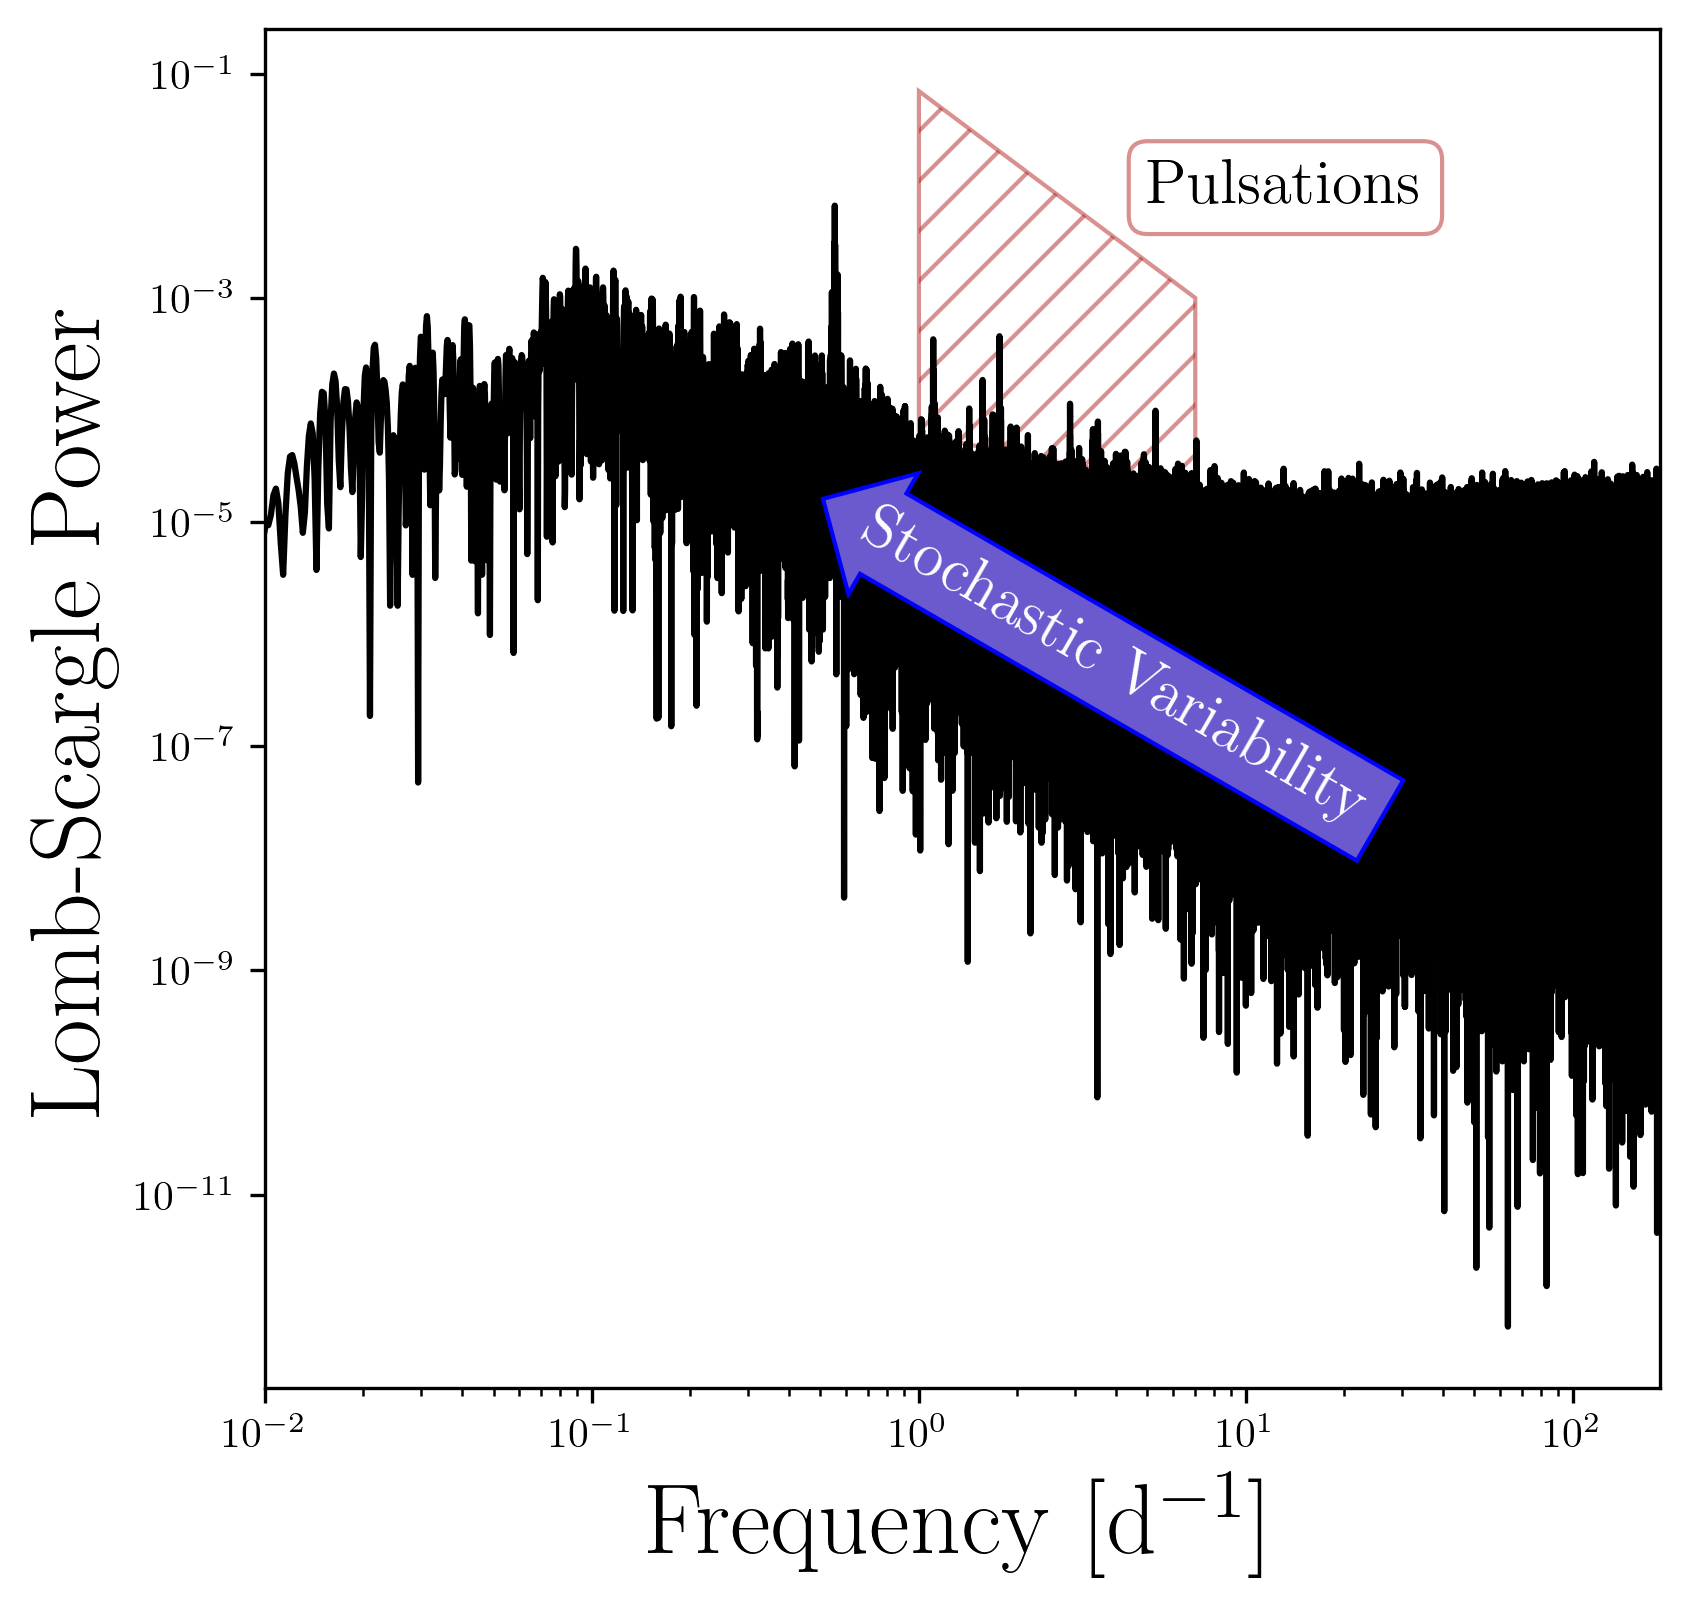

In [6]:
# A version for proposals

fig = plt.figure(figsize=(6,6),dpi=300)

plt.loglog(freq, power, c='k', rasterized=True)

plt.text(
    4, 5e-7, "Stochastic Variability", c='w', ha="center", va="center", rotation=-30, size=15,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="slateblue", ec="b",zorder=10),zorder=10)

plt.text(5,7e-3,r'Pulsations',c='k',fontdict={'fontsize':15},rotation=0,
        bbox=dict(boxstyle="round",
                   ec='firebrick',
                   fc='w',
                   alpha=0.5,zorder=-1),zorder=-1)
from matplotlib.patches import Ellipse
cx = 3
cy = 1e-3
a_x = 5
a_y = 1e-3
theta = 0
#plt.gca().add_patch(Ellipse((cx, cy), a_x, a_y, angle=theta, fill=False,edgecolor='firebrick'))
coords = np.array([[1,6e-5],[7,2e-5],[7,1e-3],[1,7e-2]])
poly = plt.Polygon(coords,ec='firebrick',fc='white',alpha=0.5,hatch='//')
plt.gca().add_patch(poly)
plt.xlim(1e-2,freq.max())

plt.xlabel('Frequency [d$^{-1}$]',fontsize=24)
plt.ylabel('Lomb-Scargle Power',fontsize=24)

plt.savefig('../../Jobs/NSF_AAPF_2021/fyps_ex.pdf',bbox_inches='tight')

In [7]:
# we'll also need the results from the SLFV posterior emcee stuff
slfv_emcee = pd.read_csv('slfv_params.csv')
slfv_ex = slfv_emcee[slfv_emcee['tic'] == example.index[0]]
slfv_ex

,tic,alpha,alpha_err_lo,alpha_err_hi,tau,tau_err_lo,tau_err_hi,gamma,gamma_err_lo,gamma_err_hi,alphaw,alphaw_err_lo,alphaw_err_hi
51,40404470,0.010105,0.00064,0.00065,0.310761,0.024964,0.026183,1.485642,0.036968,0.038031,0.0012,0.000001,0.000001


## We have a nice prior on what frequencies to expect from the non-GP prewhitening run

In [5]:
with h5.File('prewhitening.hdf5','r') as pw:
    good_fs = pw[f'{tic}/good_fs'][()]
    good_amps = pw[f'{tic}/good_amps'][()]
    good_phases = pw[f'{tic}/good_phases'][()]
good_fs

array([[5.52945117e-01, 7.68213310e-06],
       [1.76338417e+00, 2.90828253e-05],
       [5.64037515e-01, 1.60211240e-05],
       [5.41929841e-01, 1.88342374e-05],
       [2.89785194e+00, 5.85828682e-05]])

# TO DO: do the periodic stuff as sums of sin + cos w/ no phase. Do I remember my trig identities? No. So I'll use: https://www.myphysicslab.com/springs/trig-identity-en.html

In [6]:
# Here's a cute function that does that, but the mean can be any number of sinusoids!
def pm_fit_gp_sin(time, flux, err, fs=None, amps=None, phases=None, model=None, return_var=False, thin=50):
    """
    Use PyMC3 to do a maximum likelihood fit for a GP + multiple periodic signals
    
    Inputs
    ------
    time : array-like
        Times of observations
    flux : array-like
        Observed fluxes
    err : array-like
        Observational uncertainties    
    fs : array-like, elements are PyMC3 distributions
        Array with frequencies to fit, default None (i.e., only the GP is fit)
    amps : array-like, elements are PyMC3 distributions
        Array with amplitudes to fit, default None (i.e., only the GP is fit)
    phases : array-like, elements are PyMC3 distributions
        Array with phases to fit, default None (i.e., only the GP is fit)
    model : `pymc3.model.Model`
        PyMC3 Model object, will fail unless given
    return_var : bool, default True
        If True, returns the variance of the GP
    thin : integer, default 50
        Calculate the variance of the GP every `thin` points.
        
    Returns
    -------
    map_soln : dict
        Contains best-fit parameters and the gp predictions
    logp : float
        The log-likelihood of the model
    bic : float
        The Bayesian Information Criterion, -2 ln P + m ln N
    var : float
        If `return_var` is True, returns the variance of the GP
    """
    
    assert model is not None, "Must provide a PyMC3 model object"
    
    #Step 1: Mean model
    mean_flux = pm.Normal("mean_flux", mu = 1.0, sigma=np.std(flux))
    if fs is not None:
        #Making a callable for celerite
        mean_model = tt.sum([a * tt.sin(2.0*np.pi*f*time + phi) for a,f,phi in zip(amps,fs,phases)],axis=0) + mean_flux
        #And add it to the model
        pm.Deterministic("mean", mean_model)

    else:
        mean_model = mean_flux
        mean = pm.Deterministic("mean", mean_flux)
        
    #Step 2: Compute Lomb-Scargle Periodogram
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    rayleigh = 1.0 / (time.max() - time.min())
    ls = LombScargle(time,flux)
    freq,power=ls.autopower(normalization='psd',maximum_frequency=pseudo_NF)
    power /= len(time)
    
    #Step 3: Do the basic peridogram fit to guess nu_char and alpha_0
    popt, pcov, resid = fit_red_noise(freq, power)
    a0, tau_char, gamma, aw = popt
    nu_char = 1.0/(2*np.pi*tau_char)

    # A jitter term describing excess white noise (analogous to C_w)
    log_jitter = pm.Uniform("log_jitter", lower=np.log(aw)-15, upper=np.log(aw)+15, testval=np.log(np.median(np.abs(np.diff(flux)))))

    # A term to describe the SLF variability
    # sigma is the standard deviation of the GP, tau roughly corresponds to the 
    #breakoff in the power spectrum. rho and tau are related by a factor of 
    #pi/Q (the quality factor)

    #guesses for our parameters
    omega_0_guess = 2*np.pi*nu_char
    Q_guess = 1/np.sqrt(2)
    sigma_guess = a0 * np.sqrt(omega_0_guess*Q_guess) * np.power(np.pi/2.0, 0.25)
    
    #sigma
    logsigma = pm.Uniform("log_sigma", lower=np.log(sigma_guess)-10, upper=np.log(sigma_guess)+10)
    sigma = pm.Deterministic("sigma",tt.exp(logsigma))
    
    #rho (characteristic timescale)
    logrho = pm.Uniform("log_rho", lower=np.log(0.01/nu_char), upper=np.log(100.0/nu_char))
    rho = pm.Deterministic("rho", tt.exp(logrho))
    
    nuchar = pm.Deterministic("nu_char", 1.0 / rho)
    
    #tau (damping timescale)
    logtau = pm.Uniform("log_tau", lower=np.log(0.01*2.0*Q_guess/omega_0_guess),upper=np.log(100.0*2.0*Q_guess/omega_0_guess))
    tau = pm.Deterministic("tau", tt.exp(logtau))
    
    nudamp = pm.Deterministic("nu_damp", 1.0 / tau)
    
    #We also want to track Q, as it's a good estimate of how stochastic the 
    #process is.
    Q = pm.Deterministic("Q", np.pi*tau/rho)

    kernel = terms.SHOTerm(sigma=sigma, rho=rho, tau=tau)

    gp = GaussianProcess(
        kernel,
        t=time,
        diag=err ** 2.0 + tt.exp(2 * log_jitter),
        quiet=True,
    )


    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=flux-mean_model)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(flux-mean_model))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()
    logp = model.logp(map_soln)
    # parameters are tau, sigma, Q/rho, mean, jitter, plus 3 per frequency (rho is fixed)
    if fs is not None:
        n_par = 5.0 + (3.0 * len(fs))
    else:
        n_par = 5.0
    bic = -2.0*logp + n_par * np.log(len(time))
    
    #compute variance as well...
    if return_var:
        eval_in_model(gp.compute(time[::thin],yerr=err[::thin]), map_soln)
        mu, var = eval_in_model(gp.predict(flux[::thin], t=time[::thin], return_var=True), map_soln)
        return map_soln, logp, bic, var
        
    return map_soln, logp, bic

In [23]:
# Let's just keep adding sins on until we hit the minimum BIC!
maps = []
bics = []
old_bic = np.inf
for nf in range(good_fs.shape[0]+1):
    with pm.Model() as model:
        if nf == 0:
            map_soln, logp, bic = pm_fit_gp_sin(time[::5], flux[::5], err[::5], model=model)
        else:
            fs = [pm.Uniform(f"f{i}", lower = good_fs[i, 0] - 3*good_fs[i,1], upper=good_fs[i, 0] + 3*good_fs[i,1]) for i in range(nf)]
            amps = [pm.Uniform(f"a{i}", lower = np.max([good_amps[i, 0] - 3*good_amps[i,1],0.0]), upper=good_amps[i, 0] + 3*good_amps[i,1]) for i in range(nf)]
            phis = [pmx.Angle(f"phi{i}", testval = good_phases[i,0]) for i in range(nf)]
            map_soln, logp, bic = pm_fit_gp_sin(time[::5], flux[::5], err[::5], fs=fs, amps=amps, phases=phis, model=model)
    maps.append(map_soln)
    bics.append(bic)

optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: 407982.68075596273 -> 415936.6367725768
optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter, mean_flux, phi0, a0, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: 407146.9922965219 -> 416036.6305499439
optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter, mean_flux, phi1, phi0, a1, a0, f1, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: 407162.88028841594 -> 416078.89777067205
optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter, mean_flux, phi2, phi1, phi0, a2, a1, a0, f2, f1, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: 407087.27956993267 -> 416116.02687805763
optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter, mean_flux, phi3, phi2, phi1, phi0, a3, a2, a1, a0, f3, f2, f1, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: 407016.51221474964 -> 416153.12463146937
optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter, mean_flux, phi4, phi3, phi2, phi1, phi0, a4, a3, a2, a1, a0, f4, f3, f2, f1, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: 407006.71692739875 -> 416179.2476949978


In [24]:
map_soln

{'f0_interval__': array(-0.09716645),
 'f1_interval__': array(0.34419391),
 'f2_interval__': array(-0.23812827),
 'f3_interval__': array(-0.30855875),
 'f4_interval__': array(-0.48556773),
 'a0_interval__': array(-0.13083686),
 'a1_interval__': array(0.074104),
 'a2_interval__': array(-0.44025328),
 'a3_interval__': array(0.30142696),
 'a4_interval__': array(0.25641007),
 'phi0_angle__': array([4.39275908, 0.838852  ]),
 'phi1_angle__': array([4.31316944, 1.18176729]),
 'phi2_angle__': array([ 1.35685668, -4.26133054]),
 'phi3_angle__': array([-2.7757056 ,  3.50648809]),
 'phi4_angle__': array([-4.44024759,  0.53310534]),
 'mean_flux': array(1.00002242),
 'log_jitter_interval__': array(-0.04938978),
 'log_sigma_interval__': array(0.70230066),
 'log_rho_interval__': array(-0.62501224),
 'log_tau_interval__': array(-1.89137528),
 'f0': array(0.552944),
 'f1': array(1.76339904),
 'f2': array(0.56403182),
 'f3': array(0.54192119),
 'f4': array(2.89781009),
 'a0': array(0.00019306),
 'a1': 

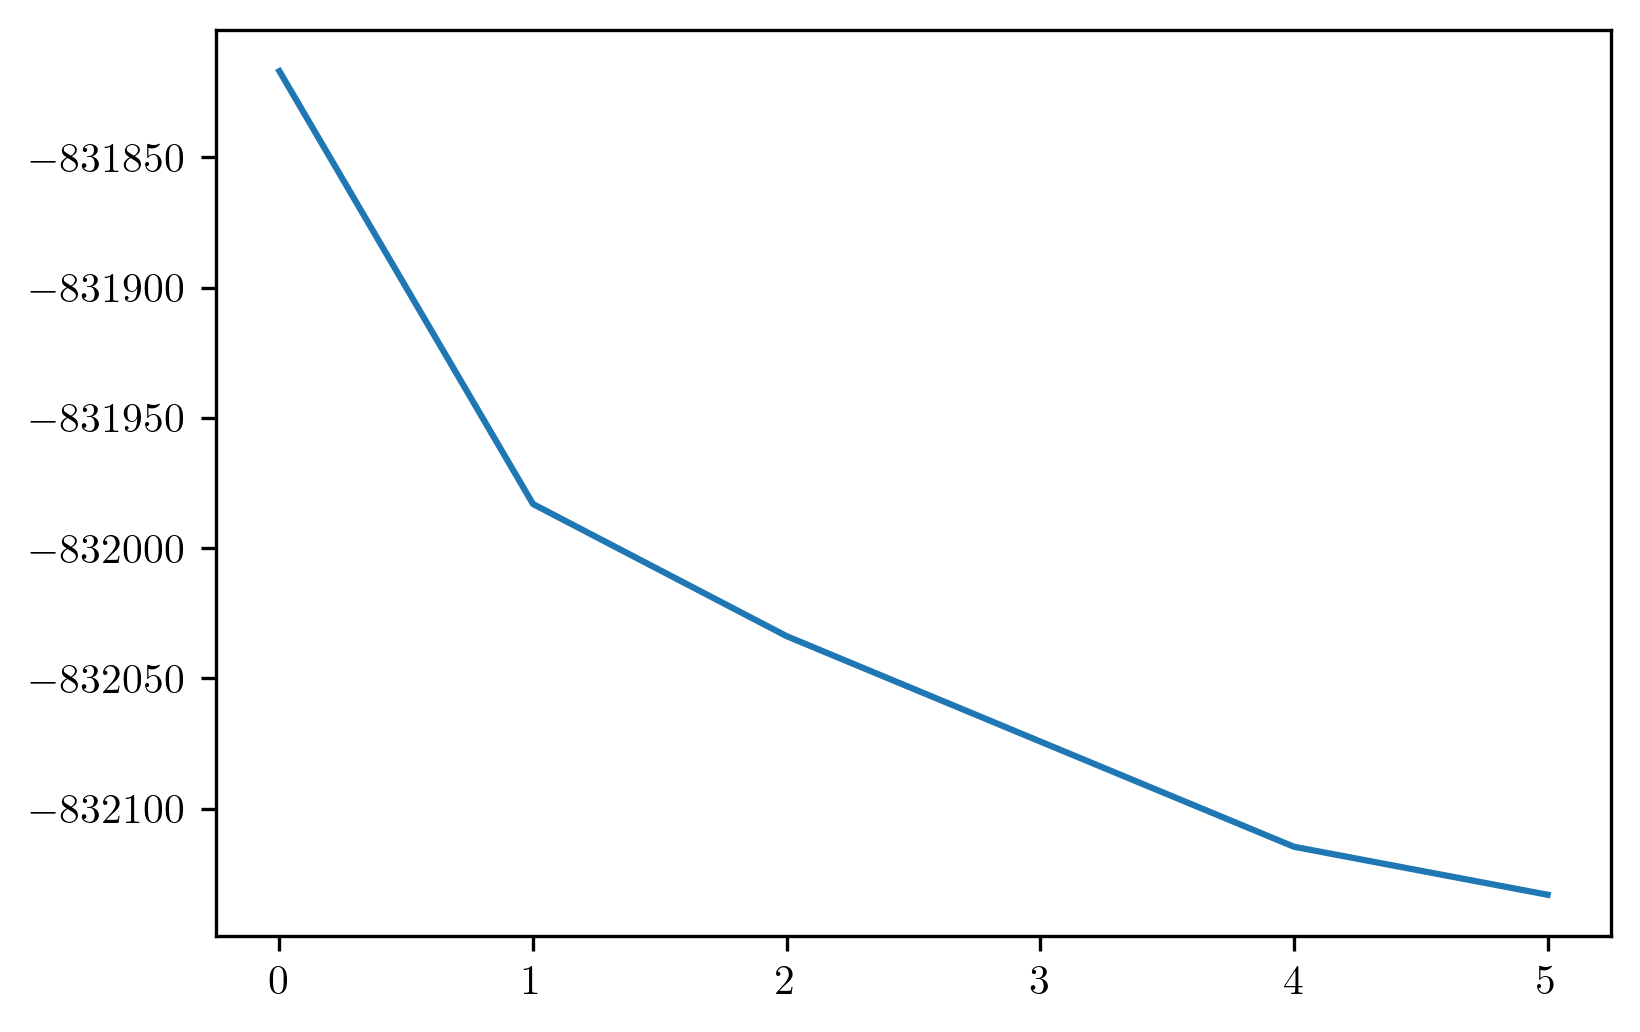

In [25]:
fig = plt.figure(dpi=300)
plt.plot(bics)

In [7]:
nf = 5#np.argmin(bics) (we know it's five)
print(nf)
with pm.Model() as model_min:
    fs = [pm.Uniform(f"f{i}", lower = good_fs[i, 0] - 3*good_fs[i,1], upper=good_fs[i, 0] + 3*good_fs[i,1]) for i in range(nf)]
    amps = [pm.Uniform(f"a{i}", lower = np.max([good_amps[i, 0] - 3*good_amps[i,1],0.0]), upper=good_amps[i, 0] + 3*good_amps[i,1]) for i in range(nf)]
    phis = [pmx.Angle(f"phi{i}", testval = good_phases[i,0]) for i in range(nf)]
    map_soln, logp, bic, var = pm_fit_gp_sin(time[::5], flux[::5], err[::5], fs=fs, amps=amps, phases=phis, model=model_min, return_var=True, thin=100)

5


optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter, mean_flux, phi4, phi3, phi2, phi1, phi0, a4, a3, a2, a1, a0, f4, f3, f2, f1, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: 407006.71692739875 -> 416179.2476949978


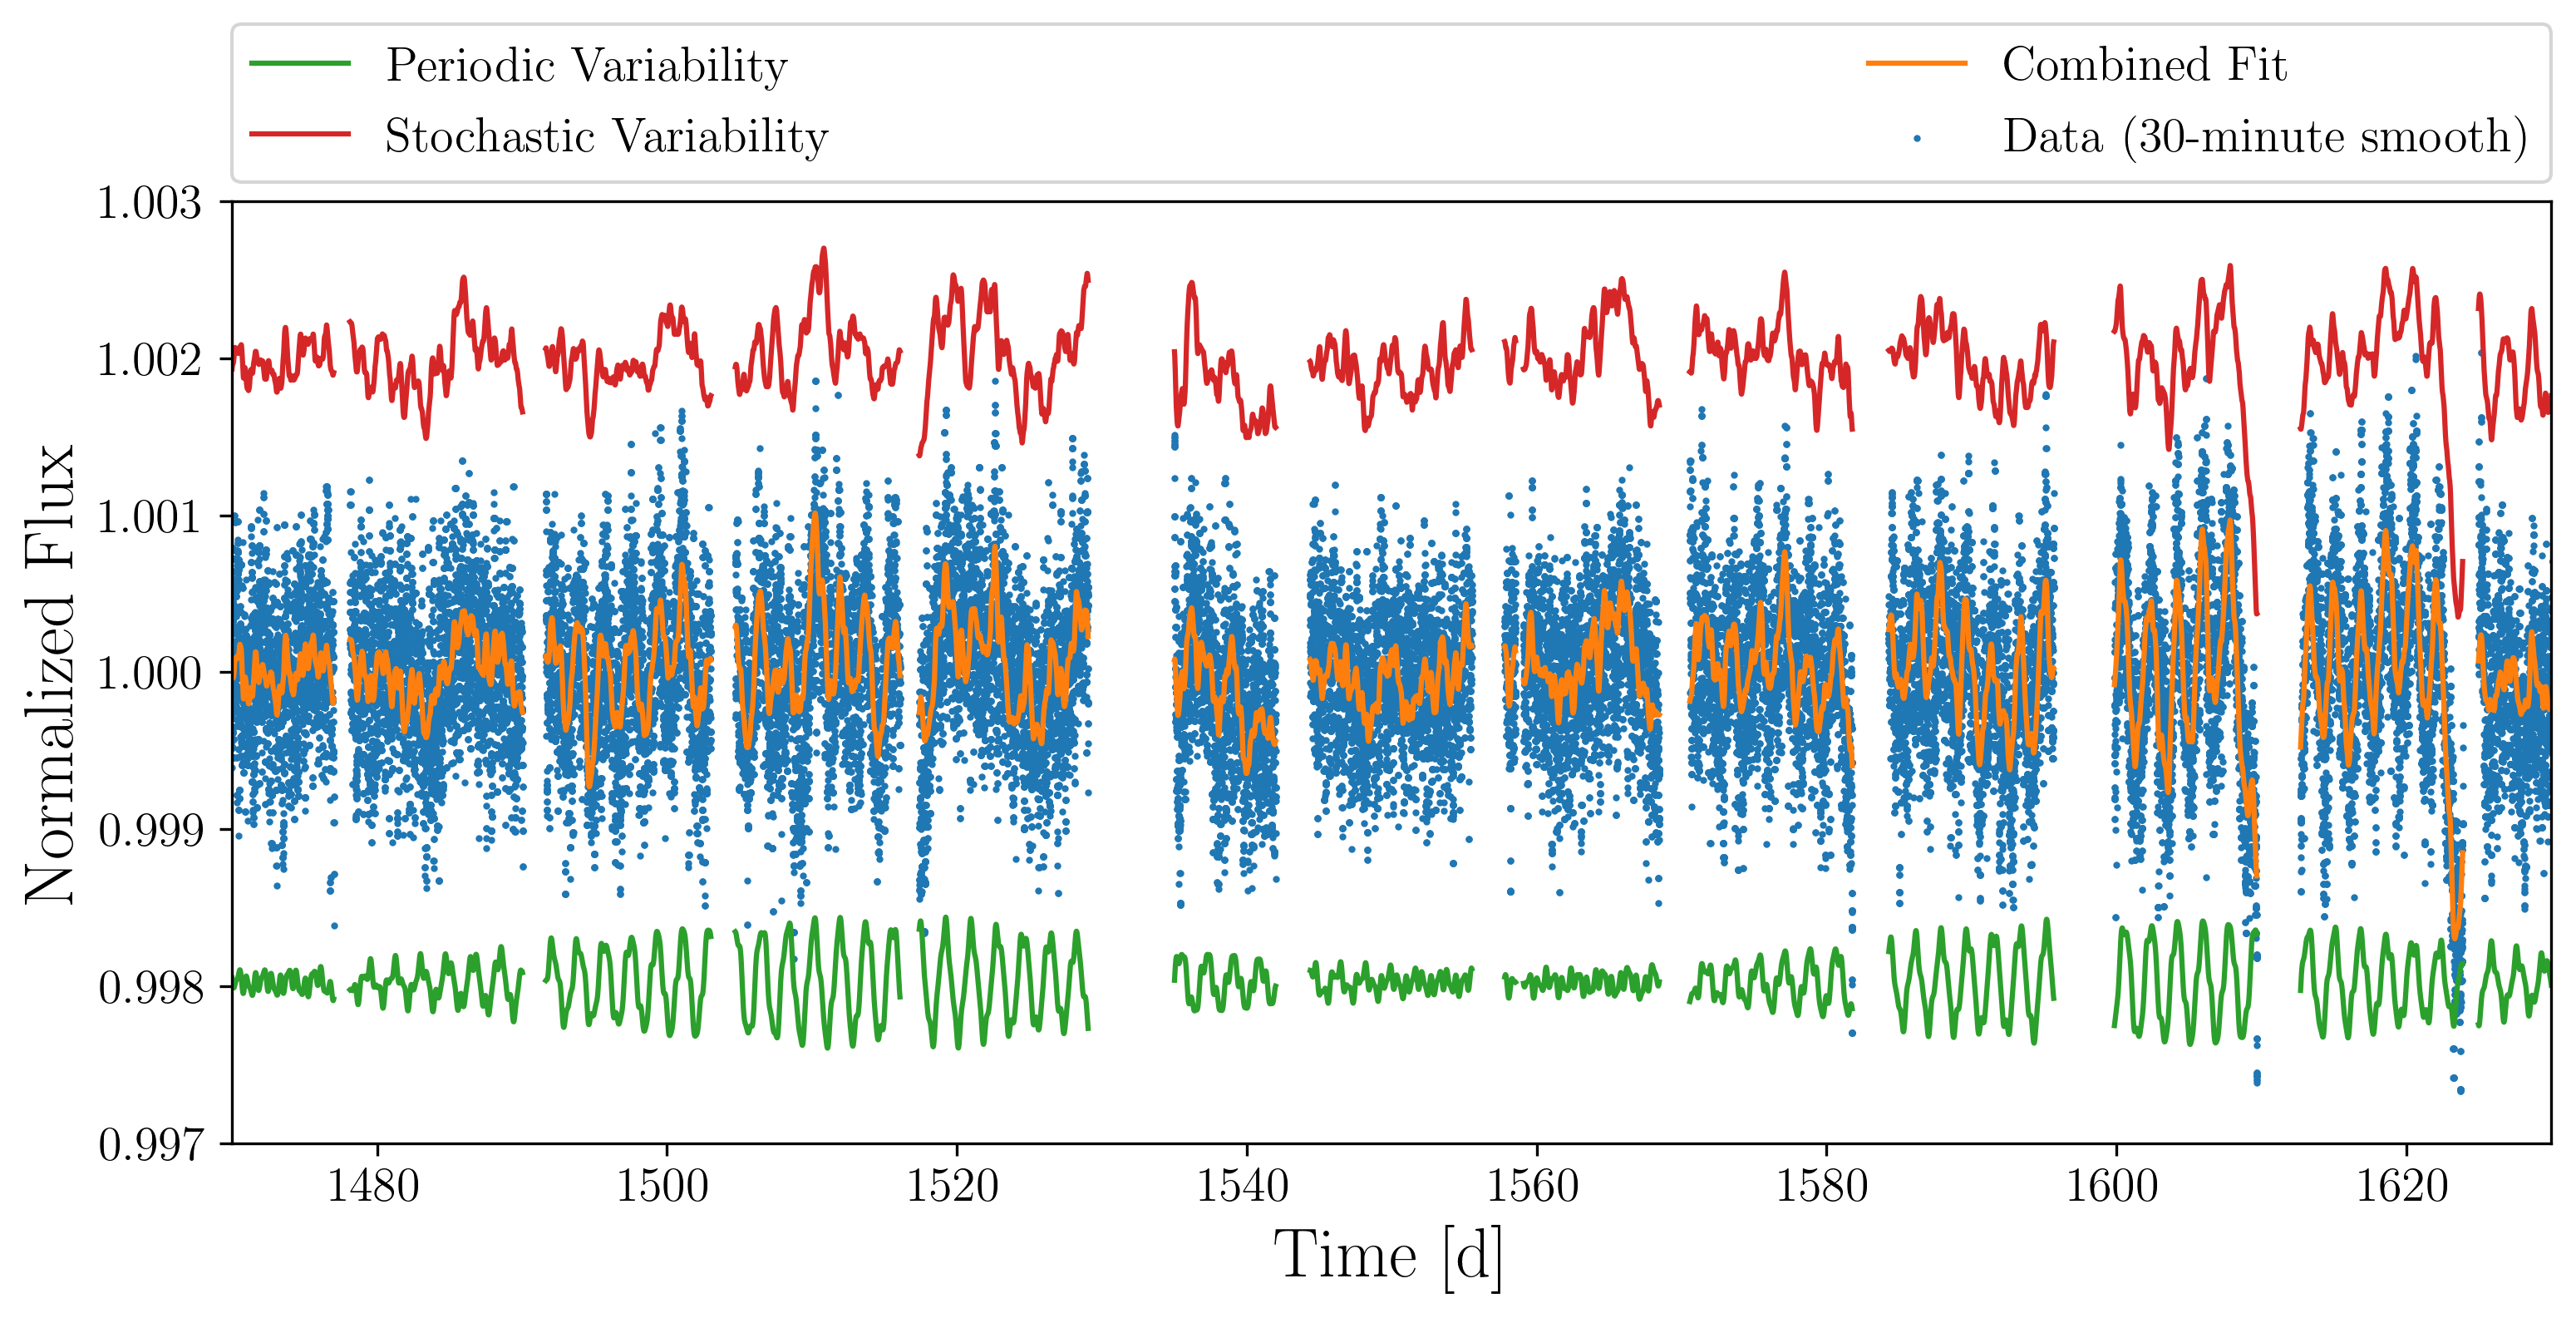

In [30]:
fig = plt.figure(figsize=(12,5),dpi=300)
plt.scatter(time_s, flux_s, s=1,rasterized=True,label='Data (30-minute smooth)')
plt.xlim(1470,1630)
plt.ylim(0.997,1.003)
xl = plt.gca().get_xlim()

mean = map_soln['mean']
pred = map_soln['pred']
diff_time = np.diff(time[::5])
skip_idx = []
for i,d in enumerate(diff_time):
    if d*24*60 >= 60:
        mean[i] = np.nan
        mean[i+1] = np.nan
        pred[i] = np.nan
        pred[i+1] = np.nan

plt.plot(time[::5], mean-0.002,c='C2',rasterized=True,label='Periodic Variability')
plt.plot(time[::5], pred+1.002,c='C3',rasterized=True,label='Stochastic Variability')
plt.plot(time[::5], mean+pred,rasterized=True,c='C1',label='Combined Fit')

for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.xlabel('Time [d]',fontsize=20)
plt.ylabel('Normalized Flux',fontsize=20)

plt.legend(ncol=2,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           mode="expand", borderaxespad=0., fontsize=14)


plt.savefig('../plots/GP_deblend.pdf', bbox_inches='tight')

In [45]:
old_bic = 20
len_good = 12
for nf_found in range(len_good+1):
    print(nf_found)
    if nf_found == 0:
        continue # we already did this case
    else:
        bic = nf_found
        if bic >= old_bic:
            print('Over the old bic!')
            break
        elif nf_found != len_good:
            print('Not yet!')
        else:
            print('Just did the final frequency!')

0
1
Not yet!
2
Not yet!
3
Not yet!
4
Not yet!
5
Not yet!
6
Not yet!
7
Not yet!
8
Not yet!
9
Not yet!
10
Not yet!
11
Not yet!
12
Just did the final frequency!


(0.0, 100.0)

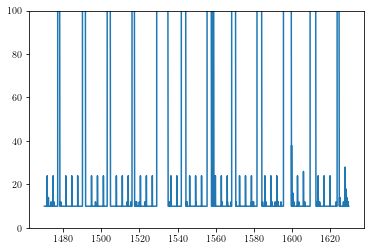

In [23]:
plt.plot(time[::5][smol_time][:-1],np.diff(time[::5][smol_time])*(24*60),rasterized=True)
plt.ylim(0,100)

In [ ]:
plt.hist(np.diff(time[smol_time])*(24*60),bins='auto');
plt.yscale('log')

In [28]:
map_soln

{'f0_interval__': array(0.41632178),
 'f1_interval__': array(-0.09767723),
 'f2_interval__': array(0.19319083),
 'f3_interval__': array(-0.52554928),
 'f4_interval__': array(1.54309938),
 'f5_interval__': array(0.61159997),
 'f6_interval__': array(-0.23404773),
 'f7_interval__': array(-0.51469226),
 'f8_interval__': array(0.01105499),
 'f9_interval__': array(-1.24627419),
 'a0_interval__': array(0.06573586),
 'a1_interval__': array(-0.51771656),
 'a2_interval__': array(-0.52377434),
 'a3_interval__': array(-0.2221121),
 'a4_interval__': array(-0.50633965),
 'a5_interval__': array(-0.09416174),
 'a6_interval__': array(-0.21839578),
 'a7_interval__': array(-0.08638103),
 'a8_interval__': array(0.2127684),
 'a9_interval__': array(-0.62446003),
 'phi0_angle__': array([-3.17015659,  3.15437744]),
 'phi1_angle__': array([ 1.50500426, -4.21128965]),
 'phi2_angle__': array([3.74669811, 2.44177208]),
 'phi3_angle__': array([-2.81660657, -3.47371829]),
 'phi4_angle__': array([ 3.01625702, -3.301

# TODO Try to run the rest of the analysis with the smoothed light curve

(1430.0, 1435.0)

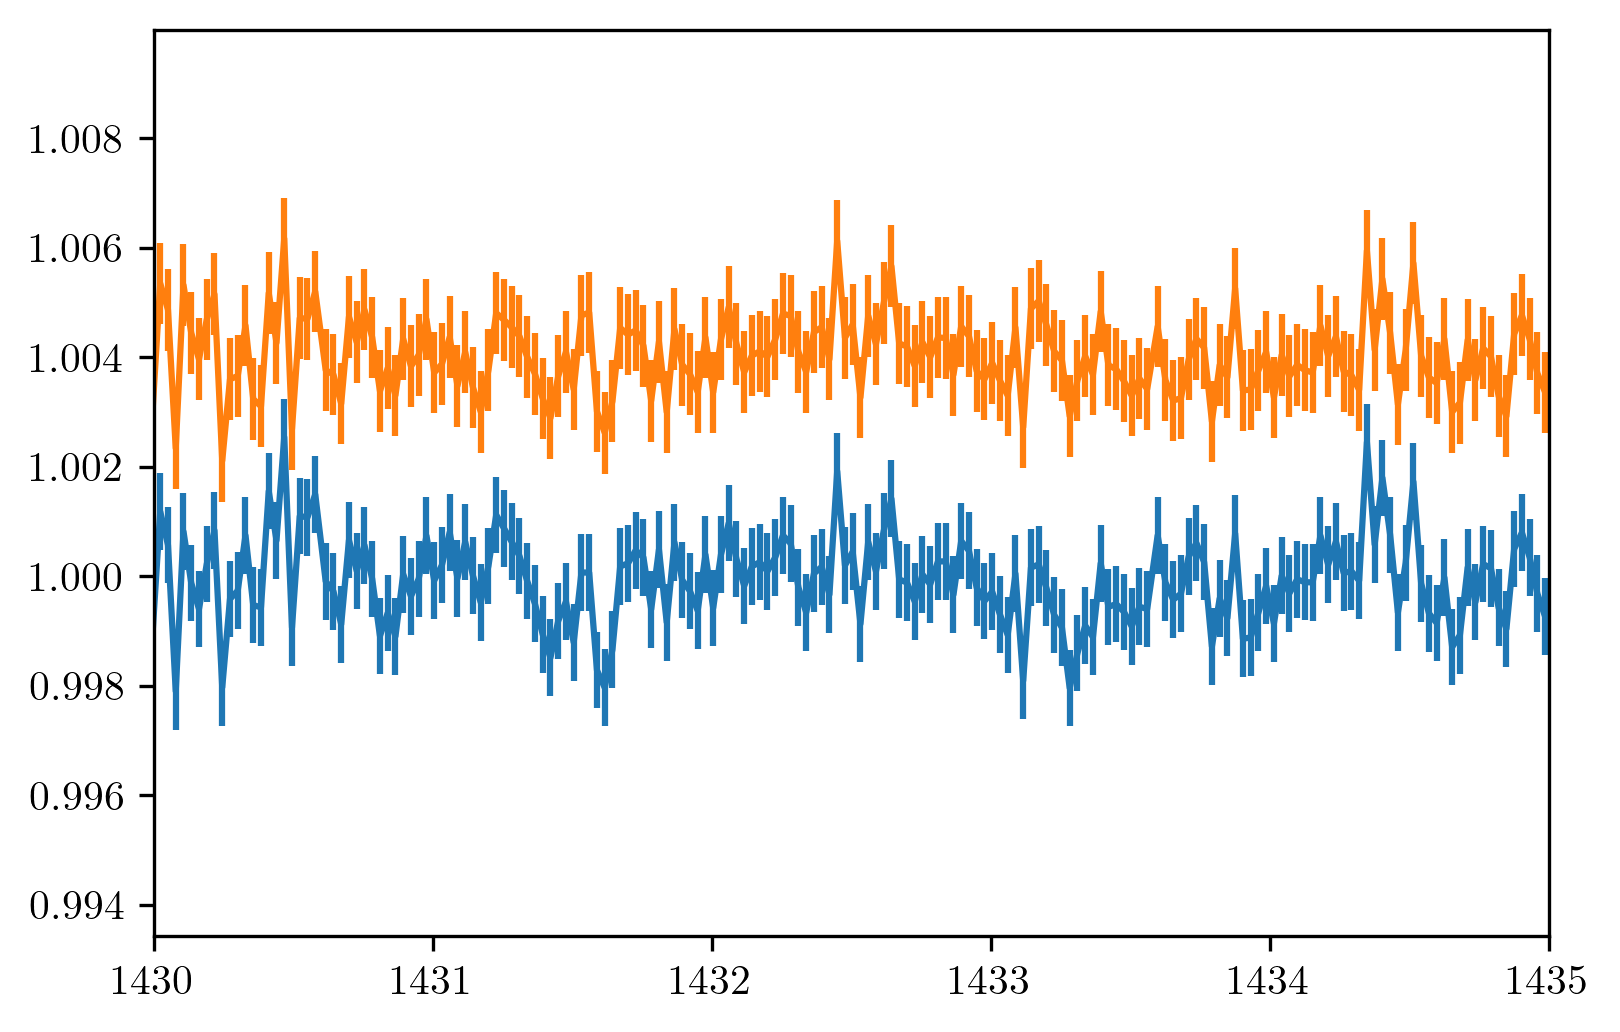

In [15]:
model_flux = map_soln['pred'] + map_soln['mean']
var_interp = np.interp(time_s[::5], time_s[::100], var)

resid_flux = flux_s - model_flux
resid_err = np.linalg.norm([err,np.sqrt(var_interp)],axis=0)

fig=plt.figure(dpi=300)

plt.errorbar(time[::20], flux[::20], yerr=err[::20],ms=1)
plt.errorbar(time[::20], resid_flux[::20]+1.004, yerr = resid_err[::20],ms=1)
plt.xlim(1430,1435)

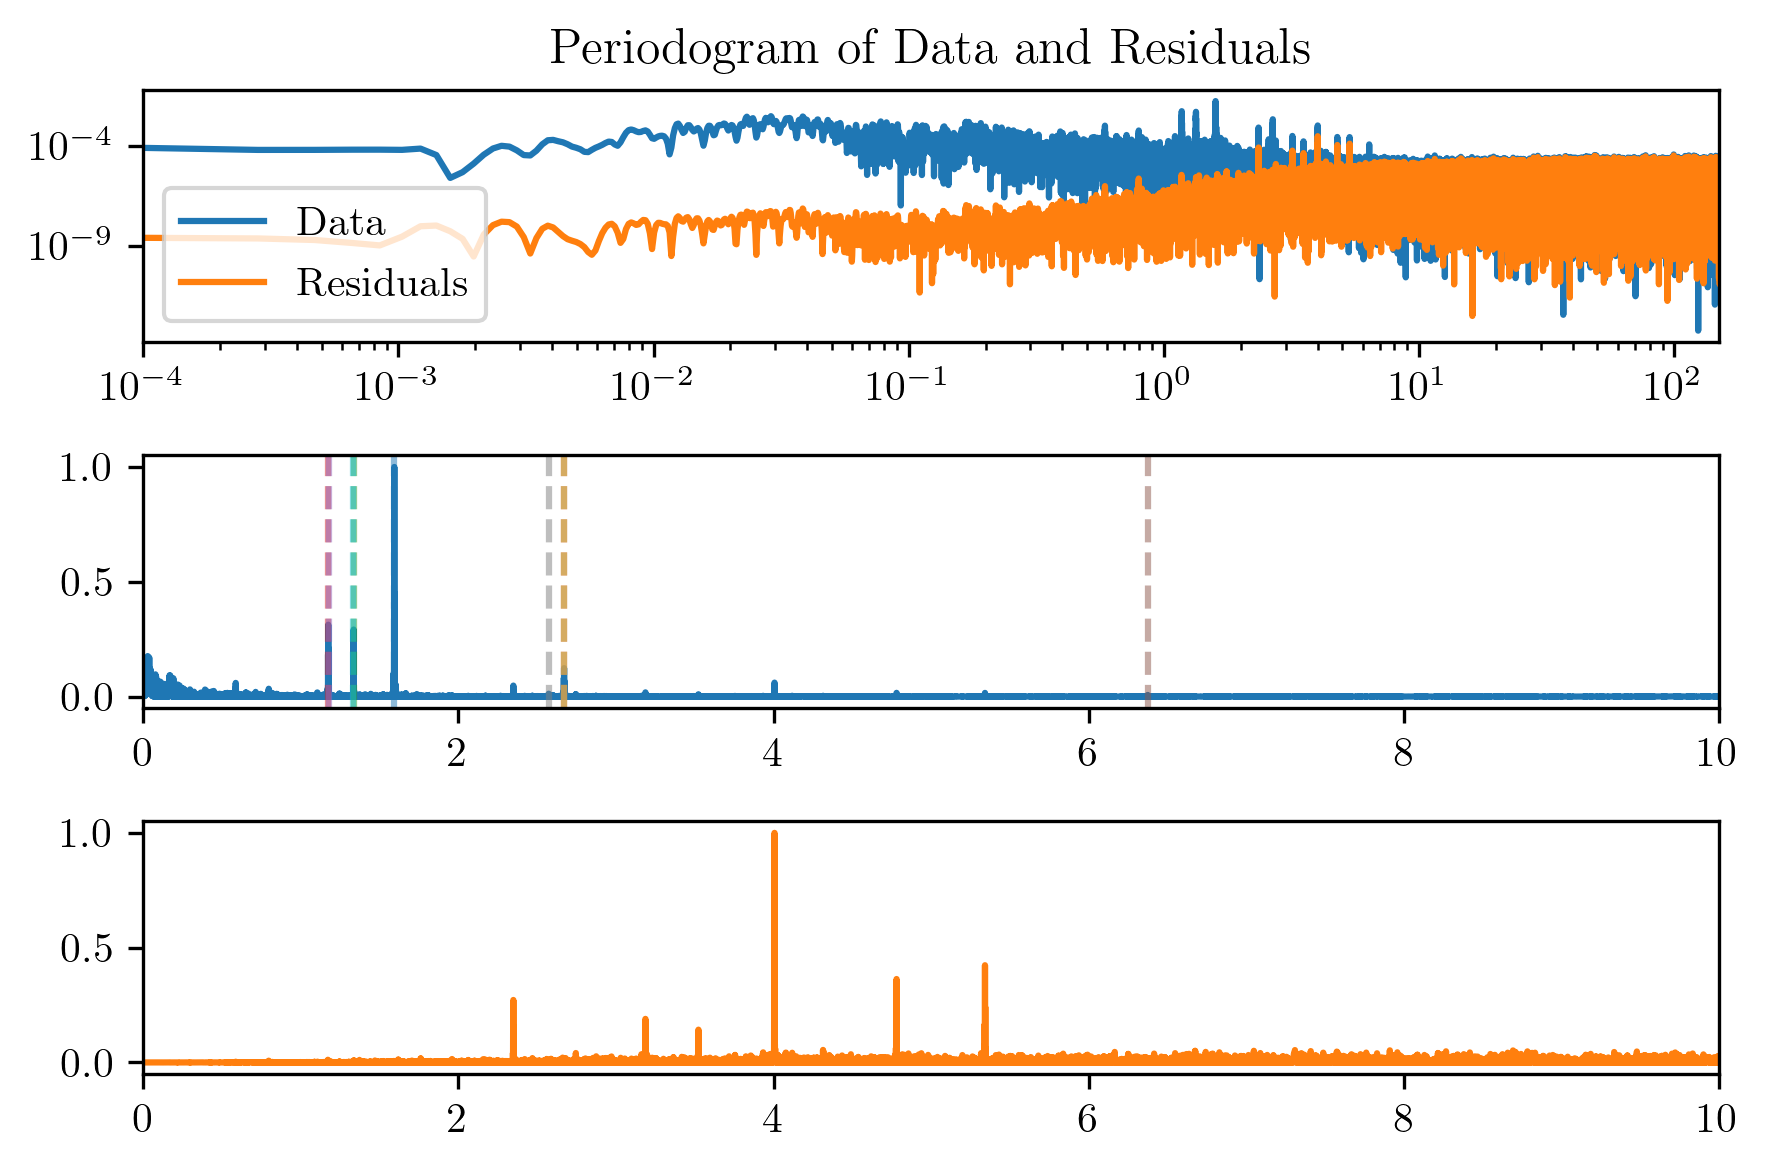

In [16]:
# Compare original with residual
ls_r = LombScargle(time,resid_flux,dy=resid_err)
freq_r,power_r=ls_r.autopower(normalization='psd',maximum_frequency=pseudo_NF)
power_r /= len(time)

fig,ax = plt.subplots(3, dpi=300)

ax[0].loglog(freq, power, label='Data')
ax[0].loglog(freq_r,power_r,label='Residuals')
ax[0].legend()
ax[0].set_xlim(1e-4,1.5e2)
ax[0].set_title('Periodogram of Data and Residuals')


ax[1].plot(freq, power/power.max())
for i in range(10):
    ax[1].axvline(x=map_soln[f'f{i}'],c=f'C{i}',alpha=0.5,ls='--')
    ax[1].axvspan(xmin=map_soln[f'f{i}']-3.0*good_fs[i,1],xmax=map_soln[f'f{i}']+3.0*good_fs[i,1],fc=f'C{i}',alpha=0.5)
ax[1].set_xlim(0,10.0)

ax[2].plot(freq_r, power_r/power_r.max(),c='C1')
ax[2].set_xlim(0,10.0)

fig.tight_layout()

In [17]:
#Step 3: prewhiten the residuals
def prewhiten_residuals(time, resid, resid_err, verbose = True, max_freq=None, max_nfreq = np.inf):
    """
    Runs through a prewhitening procedure to reproduce the variability as sin functions. 
    
    Parameters
    ----------
    time : array-like
        times
    resid : array-like
        residual fluxes after subtracting the SLFV
    resid_err : array-like
        corresponding errors.
    verbose : bool
        If True, will print out every 10th stage of prewhitening, as well as some other diagnostics
    max_freq : float, default None
        If not None, will only search for frequencies up to `max_freq`
    max_nfreq : numeric
        Determines the number of frequencies to fit for if given. Default `np.inf`
    final_fit : bool
        If set, will perform one final fit on all recovered frequencies simultaneously, and adjust the errors accordingly.
        
    Returns
    -------
    good_fs : `~numpy.ndarray`
        Nx2 array with first dimension frequencies, and the second errors
    good_amps :`~numpy.ndarray`
        Nx2 array with first dimension amplitudes, and the second errors
    good_phases :`~numpy.ndarray`
        Nx2 array with first dimension amplitudes, and the second errors
    good_snrs :`~numpy.ndarray`
        1D array with signal to noise, calculated directly from the periodogram
    good_peaks :`~numpy.ndarray`
        1D array with the heights of the extracted peaks.
    f_out : `~numpy.ndarray`
        Array with periodogram frequencies
    p_out = `~numpy.ndarray`
        Array with periodogram power (we're going to want to save this)
    
    """
    
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    rayleigh = 1.0 / (np.max(time)-np.min(time))

    #Step 1: subtract off the mean, save original arrays for later
    resid -= np.mean(resid)
    time -= np.mean(time)
    
    original_resid = resid.copy()
    original_rerr = resid_err.copy()
    original_time = time.copy()

    found_fs = []
    err_fs = []
    found_amps = []
    err_amps = []
    found_phases = []
    err_phases = []
    found_peaks = []
    found_snrs = []

    #Step 2: Calculate the Lomb Scargle periodogram
    ls = LombScargle(time, resid, dy=resid_err, normalization='psd')
    frequency, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF)
    power /= len(time) #putting into the right units
    
    f_out = frequency
    p_out = power #we're going to want to output this later

    #Step 3: Find frequency of max residual power, and the SNR of that peak
    f_0 = frequency[np.argmax(power)]
    if max_freq is not None:
        f_0 = frequency[np.argmax(power[frequency <= max_freq])]
    noise_region = (np.abs(frequency - f_0)/rayleigh < 7) & (np.abs(frequency - f_0)/rayleigh > 2)
    found_peaks.append(power.max())
    found_snrs.append(power.max()/np.std(power[noise_region]))

    #Step 4: Fit the sin. Initial guess is that frequency, the max flux point, and no phase
    # Then save the fit params
    p0 = [f_0, np.max(resid), 0]
    bounds = ([f_0-rayleigh,0,-np.inf],[f_0+rayleigh,np.inf,np.inf])

    popt, pcov = curve_fit(parametrized_sin, time, resid, bounds=bounds, p0=p0)

    found_fs.append(popt[0])
    found_amps.append(popt[1])
    phase = popt[2]
    while phase >= np.pi:
        phase -= 2.0*np.pi
    while phase <= -np.pi:
        phase += 2.0*np.pi
    found_phases.append(phase)

    #Calculate the errors
    err_fs.append(np.sqrt(6.0/len(time)) * rayleigh * np.std(resid) / (np.pi * popt[1]))
    err_amps.append(np.sqrt(2.0/len(time)) * np.std(resid))
    err_phases.append(np.sqrt(2.0/len(time)) * np.std(resid) / popt[1])

    #Calculate the BIC up to a constant: -2 log L + m log (N)
    log_like_ish = np.sum(np.power(((original_resid - np.sum([parametrized_sin(time, f, amp, phase)
                                    for f, amp, phase in zip(found_fs, found_amps, found_phases)],
                                    axis=0)) / original_rerr),2.0))

    bic = log_like_ish + 3.0*len(found_fs)*np.log(len(time))
    #bic with no fit is:
    old_bic = np.sum(np.power((original_resid/ original_rerr),2.0))
    bic_dif = bic - old_bic

    #subtract off the fit
    resid -= parametrized_sin(time, *popt)

    #now loop until BIC hits a minimum
    j = 0
    while (bic_dif <= 0) and (len(found_fs) <= max_nfreq):
        #Reset old_bic
        old_bic = bic
        #Lomb Scargle
        ls = LombScargle(time, resid, dy=resid_err, normalization='psd')
        frequency, power = ls.autopower(minimum_frequency=1.0/30.0,
                        maximum_frequency=pseudo_NF)

        power /= len(time) #putting into the right units

        #Highest peak
        f_0 = frequency[np.argmax(power)]
        if max_freq is not None:
            f_0 = frequency[np.argmax(power[frequency <= max_freq])]
        noise_region = (np.abs(frequency - f_0)/rayleigh < 7) & (np.abs(frequency - f_0)/rayleigh > 2)
        found_peaks.append(power.max())
        found_snrs.append(power.max()/np.std(power[noise_region]))

        #Fit
        p0 = [f_0, np.max(resid), 0]
        bounds = ([f_0-rayleigh,0,-np.inf],[f_0+rayleigh,np.inf,np.inf])
        popt, pcov = curve_fit(parametrized_sin, time, resid, bounds=bounds, p0=p0)

        found_fs.append(popt[0])
        found_amps.append(popt[1])
        phase = popt[2]
        while phase >= np.pi:
            phase -= 2.0*np.pi
        while phase <= -np.pi:
            phase += 2.0*np.pi
        found_phases.append(phase)

        #Calculate the errors
        err_fs.append(np.sqrt(6.0/len(time)) * rayleigh * np.std(resid) / (np.pi * popt[1]))
        err_amps.append(np.sqrt(2.0/len(time)) * np.std(resid))      
        err_phases.append(np.sqrt(2.0/len(time)) * np.std(resid) / popt[1])

        #Calculate BIC 
        log_like_ish = np.sum(np.power(((original_resid - np.sum([parametrized_sin(time, f, amp, 
                                        phase) for f, amp, phase in zip(found_fs, found_amps, 
                                        found_phases)], axis=0)) / original_rerr),2.0))
        bic = log_like_ish + 3.0*len(found_fs)*np.log(len(time))
        bic_dif = bic - old_bic
        #subtract off the fit
        resid -= parametrized_sin(time, *popt)
        j+=1
        if (j % 10 == 0) and verbose:
            print(j)
    if verbose:
        print('Found {} frequencies'.format(len(found_fs)-1))
    #if we didn't find any GOOD frequencies, get rid of that ish
    if len(found_fs)-1 == 0:
        return np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), f_out, p_out
    #pop the last from each array, as it made the fit worse, then turn into numpy arrays
    found_fs = np.array(found_fs[:-1])
    found_amps = np.array(found_amps[:-1])
    found_phases = np.array(found_phases[:-1])
    found_snrs = np.array(found_snrs[:-1])
    found_peaks = np.array(found_peaks[:-1])
    err_fs = np.array(err_fs[:-1])
    err_amps = np.array(err_amps[:-1])
    err_phases = np.array(err_phases[:-1])

    #Now loop through frequencies. If any of the less-strong peaks are within 1.5/T,
    #get rid of it.
    good_fs = np.array([[found_fs[0],err_fs[0]]])
    good_amps = np.array([[found_amps[0],err_amps[0]]])
    good_phases = np.array([[found_phases[0],err_phases[0]]])
    good_snrs = np.array([found_snrs[0]])
    good_peaks = np.array([found_peaks[0]])

    for f,ef,a,ea,p,ep,s,pk in zip(found_fs[1:],err_fs[1:],found_amps[1:],err_amps[1:],found_phases[1:],err_phases[1:],found_snrs[1:],found_peaks[1:]):
        if ~np.any(np.abs(good_fs[:,0] - f) <= 1.5*rayleigh):
            good_fs = np.append(good_fs,[[f,ef]],axis=0)
            good_amps = np.append(good_amps,[[a,ea]],axis=0)
            good_phases = np.append(good_phases,[[p,ep]],axis=0)
            good_snrs = np.append(good_snrs,[s],axis=0)
            good_peaks = np.append(good_peaks, [pk],axis=0)
    if verbose:
        print('{} unique frequencies'.format(len(good_fs)))
        
    return good_fs, good_amps, good_phases, good_snrs, good_peaks, f_out, p_out

In [18]:
resid_fs, resid_amps, resid_phases, resid_snrs, resid_peaks, resid_f, resid_p = prewhiten_residuals(time, resid_flux, resid_err)

Found 5 frequencies
5 unique frequencies


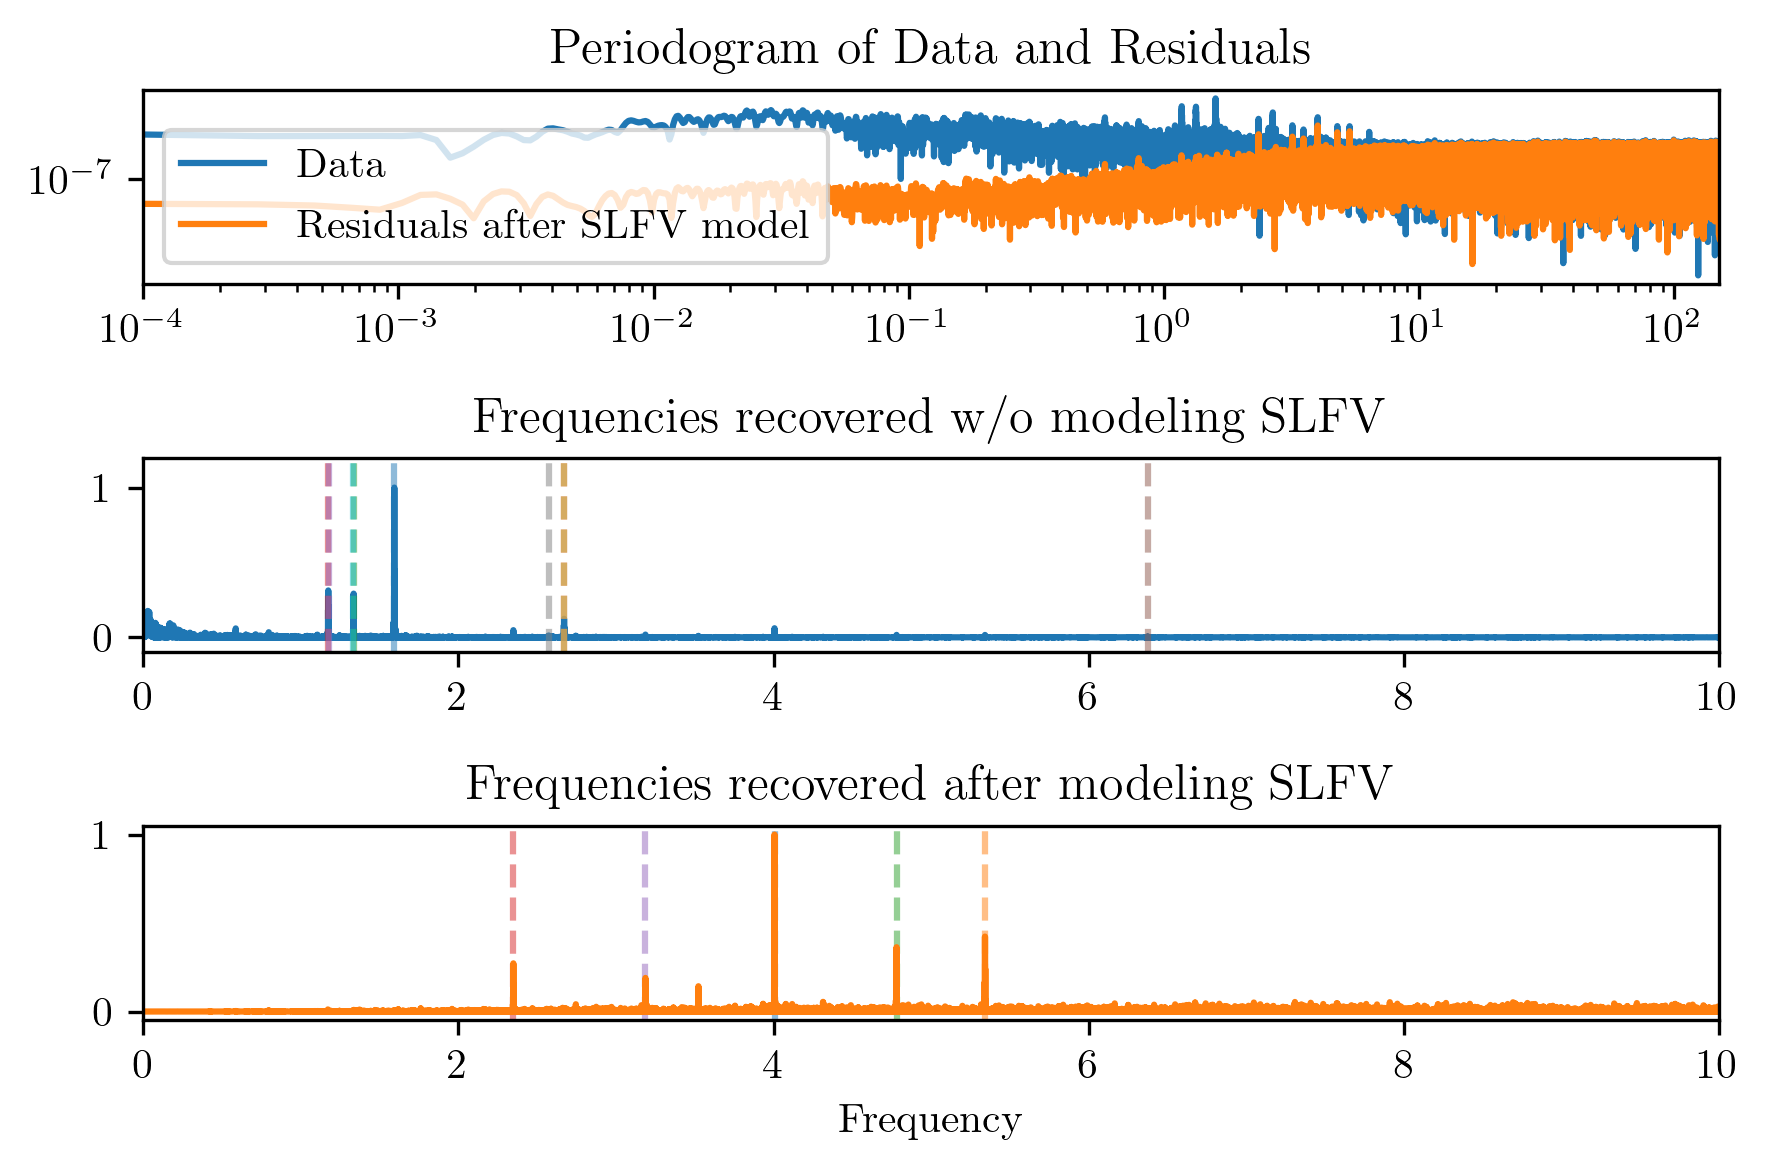

In [19]:
fig,ax = plt.subplots(3, dpi=300)

ax[0].loglog(freq, power, label='Data')
ax[0].loglog(freq_r,power_r,label='Residuals after SLFV model')
ax[0].legend()
ax[0].set_xlim(1e-4,1.5e2)
ax[0].set_title('Periodogram of Data and Residuals')


ax[1].plot(freq, power/power.max())
for i in range(nf):
    ax[1].axvline(x=map_soln[f'f{i}'],c=f'C{i}',alpha=0.5,ls='--')
ax[1].set_xlim(0,10.0)
ax[1].set_ylim(-0.1,1.2)
ax[1].set_title('Frequencies recovered w/o modeling SLFV')

for i in range(len(resid_fs)):
    ax[2].axvline(x=resid_fs[i,0],c=f'C{i}',alpha=0.5,ls='--')
ax[2].plot(freq_r, power_r/power_r.max(),c='C1')
ax[2].set_xlim(0,10.0)
ax[1].set_ylim(-0.1,1.2)
ax[2].set_title('Frequencies recovered after modeling SLFV')

ax[2].set_xlabel('Frequency')

fig.tight_layout()

In [30]:
#Finally construct the model with all frequencies and fit

freqs = []
sinamps = []
cosamps = []
amp_errs = []

a_over_b = np.tan(good_phases[:,0]) #a/b = tan(phi)
asq_bsq = np.power(good_amps[:,0],2.0) #a^2+b^2 = amp^2
            
sinamps_from_vars = np.sqrt(asq_bsq / (1.0 + a_over_b**2.0))
cosamps_from_vars = a_over_b * sinamps_from_vars

# append the extracted frequency/amplitude + old error on the amplitude from prewhitening
for i,a in enumerate(good_amps):
    if i+1 > nf:
        break
    freqs.append(map_soln[f'f{i}'].item())
    
    #going to decompose A sin (2pi*f*t + phi) into a*sin(2*pi*ft) + b*cos(2*pi*ft)
    this_phase = map_soln[f'phi{i}'].item()
    a_over_b = np.tan(this_phase) #a/b = tan(phi)
    asq_bsq = np.power(a[0],2.0) #a^2+b^2 = amp^2
    
    sinamp = np.sqrt(asq_bsq / (1.0 + a_over_b**2.0))
    cosamp = a_over_b * sinamp
    
    sinamps.append(sinamp)
    cosamps.append(cosamp)
    amp_errs.append(a[1]) #assume the error on the amplitudes is roughly the same

# append frequencies extracted from prewhitened residuals
for i,(f,a,phi) in enumerate(zip(resid_fs,resid_amps,resid_phases)):
    freqs.append(f[0])
    #going to decompose A sin (2pi*f*t + phi) into a*sin(2*pi*ft) + b*cos(2*pi*ft)
    this_phase = phi[0]
    a_over_b = np.tan(this_phase) #a/b = tan(phi)
    asq_bsq = np.power(a[0],2.0) #a^2+b^2 = amp^2
    
    sinamp = np.sqrt(asq_bsq / (1.0 + a_over_b**2.0))
    cosamp = a_over_b * sinamp
    
    sinamps.append(sinamp)
    cosamps.append(cosamp)
    amp_errs.append(a[1]) #assume the error on the amplitudes is roughly the same

print(len(freqs), len(cosamps), len(sinamps))

15 15 15


In [31]:
# Step 4: Sample the posterior
with pm.Model() as model_final:
    # A jitter term describing excess white noise (analogous to C_w)
    log_jitter = pm.Normal("log_jitter", mu=map_soln['log_jitter'].item(), sigma=5.0)

    # A term to describe the SLF variability
    # sigma is the standard deviation of the GP, tau roughly corresponds to the 
    #breakoff in the power spectrum. rho and tau are related by a factor of 
    #pi/Q (the quality factor)
    
    #sigma
    logsigma = pm.Normal("log_sigma", mu=map_soln['log_sigma'].item(), sigma=3.0)
    sigma = pm.Deterministic("sigma",tt.exp(logsigma))
    
    #rho (characteristic timescale)
    logrho = pm.Normal("log_rho", mu=map_soln['log_rho'].item(), sigma=3.0)
    rho = pm.Deterministic("rho", tt.exp(logrho))
    
    nuchar = pm.Deterministic("nu_char", 1.0 / rho)
    
    #tau (damping timescale)
    logtau = pm.Normal("log_tau", mu=map_soln['log_rho'].item(), sigma=3.0)
    tau = pm.Deterministic("tau", tt.exp(logtau))
    
    nudamp = pm.Deterministic("nu_damp", 1.0 / tau)
    
    #We also want to track Q, as it's a good estimate of how stochastic the 
    #process is.
    Q = pm.Deterministic("Q", np.pi*tau/rho)

    kernel = terms.SHOTerm(sigma=sigma, rho=rho, tau=tau)
    
    frequencies = [pm.Normal(f"f{i}", mu = f, sigma=rayleigh) for i,f in enumerate(freqs)]
    cos_amplitudes = [pm.Uniform(f"a{i}", lower=cosamps[i] - 3*amp_errs[i], upper=cosamps[i] + 3*amp_errs[i]) for i in range(len(cosamps))] 
    sin_amplitudes = [pm.Uniform(f"b{i}", lower=sinamps[i] - 3*amp_errs[i], upper=sinamps[i] + 3*amp_errs[i]) for i in range(len(sinamps))] 
    
    mean_flux = pm.Normal("mean_flux", mu = map_soln['mean_flux'].item(), sigma=np.std(flux))
    
    mean_model = tt.sum([a * tt.cos(2.0*np.pi*f*time.values) + b * tt.sin(2.0*np.pi*f*time.values) for a,b,f in zip(cos_amplitudes,sin_amplitudes,frequencies)],axis=0) + mean_flux
    #And add it to the model
    pm.Deterministic("mean", mean_model)

    gp = GaussianProcess(
        kernel,
        t=time.values,
        diag=err.values ** 2.0 + tt.exp(2 * log_jitter),
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=flux.values-mean_model)

    """# Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(flux.values-mean_model))"""
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()
    
     # We've already optimized, so we're going to sample!
    trace = pmx.sample(
        start=map_soln,
        target_accept=0.95,
        cores=8,
        chains=4,
        random_seed=42,
        recompute_interval=0,
        return_inferencedata=True)

optimizing logp for variables: [mean_flux, b14, b13, b12, b11, b10, b9, b8, b7, b6, b5, b4, b3, b2, b1, b0, a14, a13, a12, a11, a10, a9, a8, a7, a6, a5, a4, a3, a2, a1, a0, f14, f13, f12, f11, f10, f9, f8, f7, f6, f5, f4, f3, f2, f1, f0, log_tau, log_rho, log_sigma, log_jitter]


message: Desired error not necessarily achieved due to precision loss.
logp: 2174437.5166672063 -> 2179092.8041832573
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [mean_flux, b14, b13, b12, b11, b10, b9, b8, b7, b6, b5, b4, b3, b2, b1, b0, a14, a13, a12, a11, a10, a9, a8, a7, a6, a5, a4, a3, a2, a1, a0, f14, f13, f12, f11, f10, f9, f8, f7, f6, f5, f4, f3, f2, f1, f0, log_tau, log_rho, log_sigma, log_jitter]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/carina/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py", line 1477, in _mp_sample
    for draw in sampler:
  File "/Users/carina/anaconda3/lib/python3.7/site-packages/pymc3/parallel_sampling.py", line 479, in __iter__
    draw = ProcessAdapter.recv_draw(self._active)
  File "/Users/carina/anaconda3/lib/python3.7/site-packages/pymc3/parallel_sampling.py", line 346, in recv_draw
    ready = multiprocessing.connection.wait(pipes)
  File "/Users/carina/anaconda3/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/Users/carina/anaconda3/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/carina/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exe

TypeError: object of type 'NoneType' has no len()

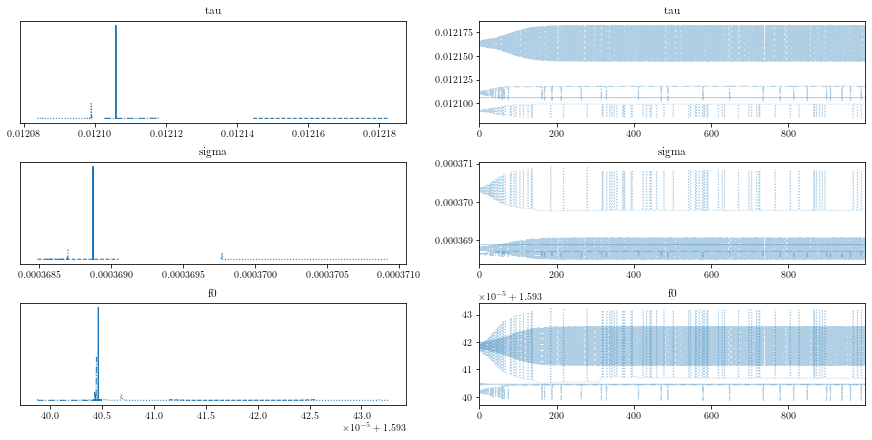

In [58]:
_ = az.plot_trace(trace, var_names=["tau", "sigma", "f0"])

In [47]:
az.summary(trace)


KeyboardInterrupt



# So here's what we're going to try first:

## 1. Fit GP as above

## 2. Subtract model from flux, adding errors in quadrature with the mean variance from every ~20th data point

## 3. Run prewhitening on the residuals

## 4. Rerun GP with full set of periods in the mean model, then sample with PyMC3 to derive all the parameters.

In [4]:
# Step 1: fit GP with no frequencies

#we need a function that fits the GP plus an optional set of sin waves
def slfv_gp_sin(time, flux, err, fs=None, amps=None, phases=None, model=None, return_var=True, thin=50):
    """
    Use PyMC3 to do a maximum likelihood fit for a GP + multiple periodic signals
    
    Inputs
    ------
    time : array-like
        Times of observations
    flux : array-like
        Observed fluxes
    err : array-like
        Observational uncertainties    
    fs : array-like, elements are PyMC3 distributions
        Array with frequencies to fit, default None (i.e., only the GP is fit)
    amps : array-like, elements are PyMC3 distributions
        Array with amplitudes to fit, default None (i.e., only the GP is fit)
    phases : array-like, elements are PyMC3 distributions
        Array with phases to fit, default None (i.e., only the GP is fit)
    model : `pymc3.model.Model`
        PyMC3 Model object, will fail unless given
    return_var : bool, default True
        If True, returns the variance of the GP
    thin : integer, default 50
        Calculate the variance of the GP every `thin` points.
        
    Returns
    -------
    map_soln : dict
        Contains best-fit parameters and the gp predictions
    logp : float
        The log-likelihood of the model
    bic : float
        The Bayesian Information Criterion, -2 ln P + m ln N
    var : float
        If `return_var` is True, returns the variance of the GP
    """
    
    assert model is not None, "Must provide a PyMC3 model object"
    
    # define the pseudo Nyquist frequency
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    
    rayleigh = 1.0 / (time.max() - time.min())
    
    mean_flux = pm.Normal("mean_flux", mu = 1.0, sigma=np.std(flux))
    if fs is not None:
        periodic = pm.Deterministic("Periodic", 
                                    tt.sum([a * tt.sin(2.0*np.pi*f*time + phi) 
                                            for a,f,phi in zip(amps,fs,phases)],
                                            axis=0)
                                   )
    else:
        periodic = 0.0

    mean = pm.Deterministic("mean", mean_flux + periodic)

    # A jitter term describing excess white noise; the lightcurve is pretty good,
    # with few-to-no sector-to-sector systematics. We'll return to this point 
    # later but for now I'm using we can use a single Jitter term.
    log_jitter = pm.Normal("log_jitter", mu=np.log(err.mean()), sigma=5.0)

    # A term to describe the non-periodic variability
    # sigma is the standard deviation, which I'm gonna guess is somewhere 
    # around the overall standard deviation of the lightcurve, plus or minus 20 
    # percent. Meanwhile, tau roughly corresponds to the breakoff in the power
    # spectrum, which occurs around 0.1 to 10 d^-1 (0.1 - 10 d periods). rho 
    # and tau are related by a factor of pi/Q (the quality factor, which we
    # hold fixed at 1/sqrt(2)


    sigma_guess = slfv_ex['alpha'].iloc[0] ** 2.0
    sigma = pm.Uniform("sigma", lower=0.5*sigma_guess, upper=1.5*sigma_guess)

    logtau = pm.Uniform("log_tau", lower=-1, upper=1)
    tau = pm.Deterministic("tau", tt.exp(logtau))
    
    Q = 1/np.sqrt(2.0) #simplify our equation here with no periodic component.
    rho = pm.Deterministic("rho", tau * np.pi / Q)

    kernel = terms.SHOTerm(sigma=sigma, rho=rho, tau=tau)

    gp = GaussianProcess(
        kernel,
        t=time,
        diag=err ** 2.0 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )


    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=flux)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(flux))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()
    logp = model.logp(map_soln)
    # parameters are tau, sigma, mean, jitter, plus 3 per frequency (rho is fixed)
    if fs is not None:
        n_par = 4.0 + (3.0 * len(fs))
    else:
        n_par = 4.0
    bic = -2.0*logp + n_par * np.log(len(time))
    
    #compute variance as well...
    if return_var:
        eval_in_model(gp.compute(time[::thin],yerr=err[::thin]), map_soln)
        mu, var = eval_in_model(gp.predict(flux[::thin], t=time[::thin], return_var=True), map_soln)
        return map_soln, logp, bic, var
        
    return map_soln, logp, bic

In [9]:
with pm.Model() as model:
    map_soln, logp, bic, var = slfv_gp_sin(time.values, flux.values, err.values, model=model)

optimizing logp for variables: [log_tau, sigma, log_jitter, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: 2143587.3605184765 -> 2171715.85408721


In [10]:
# Step 2: Compute variance of GP fit, interpolate to get errors, compute residual flux

resid = flux.values - map_soln['pred']

gp_var = np.interp(time.values, time.values[::50], var)

resid_err = np.sqrt((err.values ** 2.0) + gp_var)

(-0.002, 0.002)

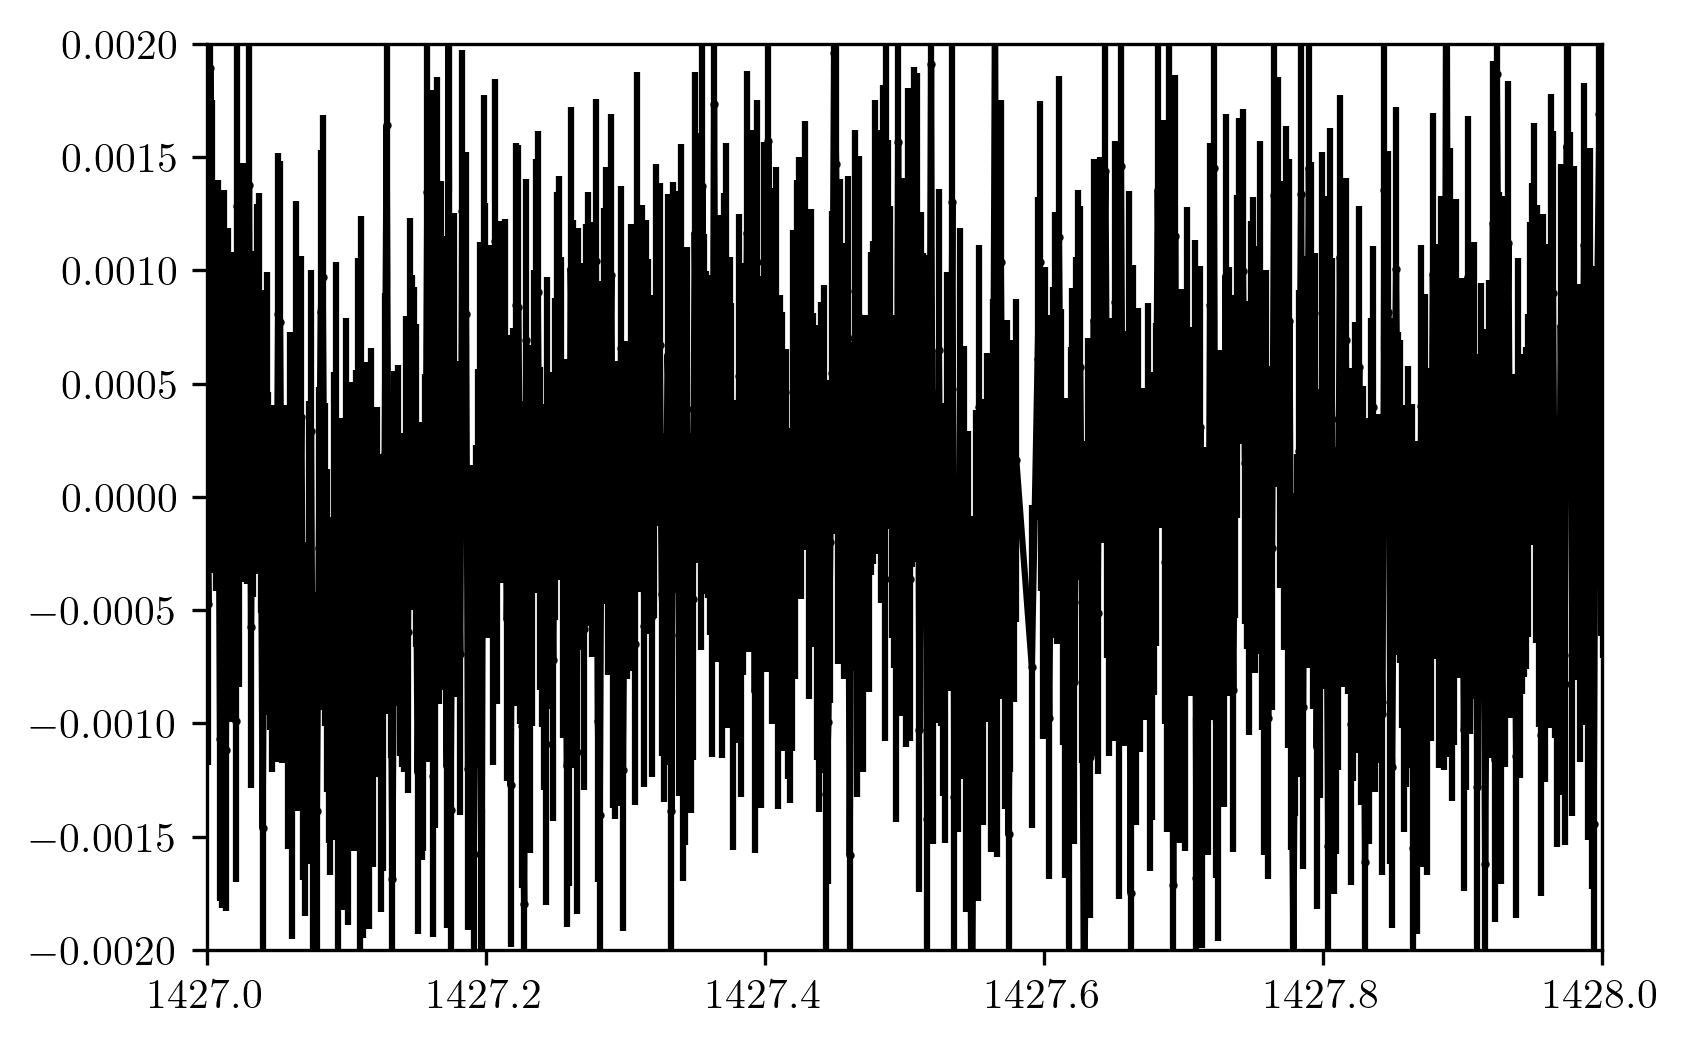

In [11]:
fig = plt.figure(dpi=300)
plt.errorbar(time, resid, resid_err, fmt='-o', markersize=1,c='k')
plt.xlim(1427,1428)
plt.ylim(-0.002,0.002)

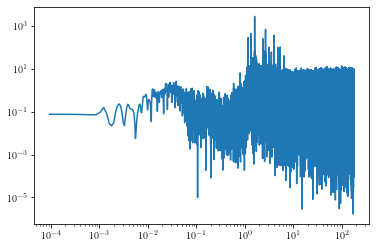

In [12]:
ls_resid = LombScargle(time-time.mean(), resid-resid.mean(), dy=resid_err, normalization='psd')
pseudo_NF = 0.5 / (np.mean(np.diff(time)))
f_resid, p_resid = ls_resid.autopower(maximum_frequency=pseudo_NF) 
plt.loglog(f_resid, p_resid)

(1.0, 5.5)

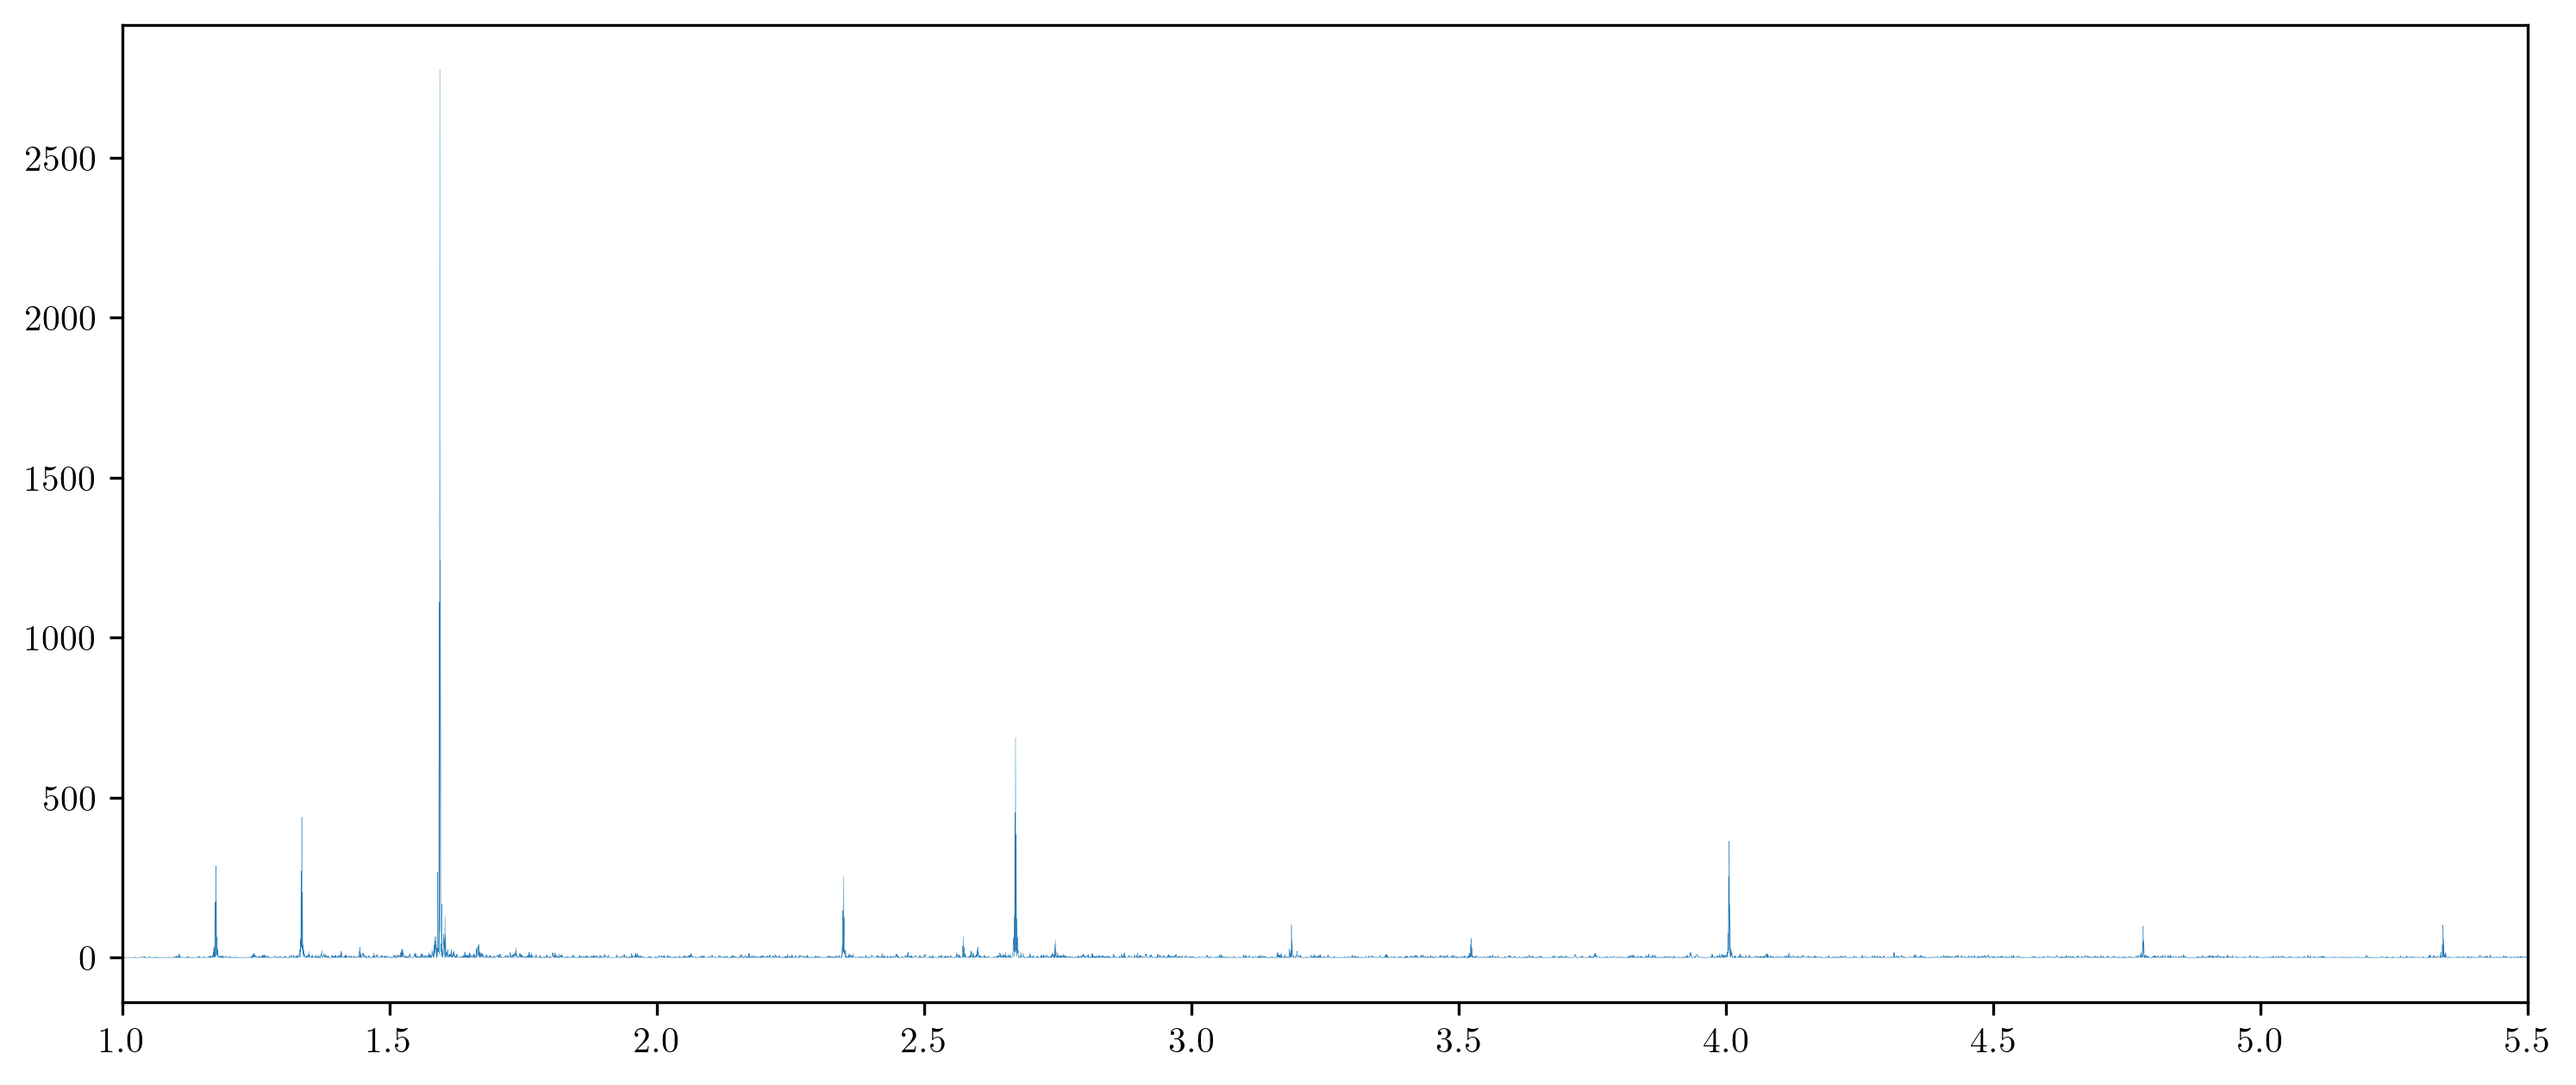

In [13]:
fig = plt.figure(dpi=300,figsize=(12,5))
plt.plot(f_resid, p_resid, lw=0.1)
plt.xlim(1,5.5)

In [14]:
#Step 3: prewhiten the residuals
def prewhiten_residuals(time, resid, resid_err, verbose = True, max_freq=None, max_nfreq = np.inf):
    """
    Runs through a prewhitening procedure to reproduce the variability as sin functions. 
    
    Parameters
    ----------
    time : array-like
        times
    resid : array-like
        residual fluxes after subtracting the SLFV
    resid_err : array-like
        corresponding errors.
    verbose : bool
        If True, will print out every 10th stage of prewhitening, as well as some other diagnostics
    max_freq : float, default None
        If not None, will only search for frequencies up to `max_freq`
    max_nfreq : numeric
        Determines the number of frequencies to fit for if given. Default `np.inf`
    final_fit : bool
        If set, will perform one final fit on all recovered frequencies simultaneously, and adjust the errors accordingly.
        
    Returns
    -------
    good_fs : `~numpy.ndarray`
        Nx2 array with first dimension frequencies, and the second errors
    good_amps :`~numpy.ndarray`
        Nx2 array with first dimension amplitudes, and the second errors
    good_phases :`~numpy.ndarray`
        Nx2 array with first dimension amplitudes, and the second errors
    good_snrs :`~numpy.ndarray`
        1D array with signal to noise, calculated directly from the periodogram
    good_peaks :`~numpy.ndarray`
        1D array with the heights of the extracted peaks.
    f_out : `~numpy.ndarray`
        Array with periodogram frequencies
    p_out = `~numpy.ndarray`
        Array with periodogram power (we're going to want to save this)
    
    """
    
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    rayleigh = 1.0 / (np.max(time)-np.min(time))

    #Step 1: subtract off the mean, save original arrays for later
    resid -= np.mean(resid)
    time -= np.mean(time)
    
    original_resid = resid.copy()
    original_rerr = resid_err.copy()
    original_time = time.copy()

    found_fs = []
    err_fs = []
    found_amps = []
    err_amps = []
    found_phases = []
    err_phases = []
    found_peaks = []
    found_snrs = []

    #Step 2: Calculate the Lomb Scargle periodogram
    ls = LombScargle(time, resid, dy=resid_err, normalization='psd')
    frequency, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF)
    power /= len(time) #putting into the right units
    
    f_out = frequency
    p_out = power #we're going to want to output this later

    #Step 3: Find frequency of max residual power, and the SNR of that peak
    f_0 = frequency[np.argmax(power)]
    if max_freq is not None:
        f_0 = frequency[np.argmax(power[frequency <= max_freq])]
    noise_region = (np.abs(frequency - f_0)/rayleigh < 7) & (np.abs(frequency - f_0)/rayleigh > 2)
    found_peaks.append(power.max())
    found_snrs.append(power.max()/np.std(power[noise_region]))

    #Step 4: Fit the sin. Initial guess is that frequency, the max flux point, and no phase
    # Then save the fit params
    p0 = [f_0, np.max(resid), 0]
    bounds = ([f_0-rayleigh,0,-np.inf],[f_0+rayleigh,np.inf,np.inf])

    popt, pcov = curve_fit(parametrized_sin, time, resid, bounds=bounds, p0=p0)

    found_fs.append(popt[0])
    found_amps.append(popt[1])
    phase = popt[2]
    while phase >= np.pi:
        phase -= 2.0*np.pi
    while phase <= -np.pi:
        phase += 2.0*np.pi
    found_phases.append(phase)

    #Calculate the errors
    err_fs.append(np.sqrt(6.0/len(time)) * rayleigh * np.std(resid) / (np.pi * popt[1]))
    err_amps.append(np.sqrt(2.0/len(time)) * np.std(resid))
    err_phases.append(np.sqrt(2.0/len(time)) * np.std(resid) / popt[1])

    #Calculate the BIC up to a constant: -2 log L + m log (N)
    log_like_ish = np.sum(np.power(((original_resid - np.sum([parametrized_sin(time, f, amp, phase)
                                    for f, amp, phase in zip(found_fs, found_amps, found_phases)],
                                    axis=0)) / original_rerr),2.0))

    bic = log_like_ish + 3.0*len(found_fs)*np.log(len(time))
    #bic with no fit is:
    old_bic = np.sum(np.power((original_resid/ original_rerr),2.0))
    bic_dif = bic - old_bic

    #subtract off the fit
    resid -= parametrized_sin(time, *popt)

    #now loop until BIC hits a minimum
    j = 0
    while (bic_dif <= 0) and (len(found_fs) <= max_nfreq):
        #Reset old_bic
        old_bic = bic
        #Lomb Scargle
        ls = LombScargle(time, resid, dy=resid_err, normalization='psd')
        frequency, power = ls.autopower(minimum_frequency=1.0/30.0,
                        maximum_frequency=pseudo_NF)

        power /= len(time) #putting into the right units

        #Highest peak
        f_0 = frequency[np.argmax(power)]
        if max_freq is not None:
            f_0 = frequency[np.argmax(power[frequency <= max_freq])]
        noise_region = (np.abs(frequency - f_0)/rayleigh < 7) & (np.abs(frequency - f_0)/rayleigh > 2)
        found_peaks.append(power.max())
        found_snrs.append(power.max()/np.std(power[noise_region]))

        #Fit
        p0 = [f_0, np.max(resid), 0]
        bounds = ([f_0-rayleigh,0,-np.inf],[f_0+rayleigh,np.inf,np.inf])
        popt, pcov = curve_fit(parametrized_sin, time, resid, bounds=bounds, p0=p0)

        found_fs.append(popt[0])
        found_amps.append(popt[1])
        phase = popt[2]
        while phase >= np.pi:
            phase -= 2.0*np.pi
        while phase <= -np.pi:
            phase += 2.0*np.pi
        found_phases.append(phase)

        #Calculate the errors
        err_fs.append(np.sqrt(6.0/len(time)) * rayleigh * np.std(resid) / (np.pi * popt[1]))
        err_amps.append(np.sqrt(2.0/len(time)) * np.std(resid))      
        err_phases.append(np.sqrt(2.0/len(time)) * np.std(resid) / popt[1])

        #Calculate BIC 
        log_like_ish = np.sum(np.power(((original_resid - np.sum([parametrized_sin(time, f, amp, 
                                        phase) for f, amp, phase in zip(found_fs, found_amps, 
                                        found_phases)], axis=0)) / original_rerr),2.0))
        bic = log_like_ish + 3.0*len(found_fs)*np.log(len(time))
        bic_dif = bic - old_bic
        #subtract off the fit
        resid -= parametrized_sin(time, *popt)
        j+=1
        if (j % 10 == 0) and verbose:
            print(j)
    if verbose:
        print('Found {} frequencies'.format(len(found_fs)-1))
    #if we didn't find any GOOD frequencies, get rid of that ish
    if len(found_fs)-1 == 0:
        return np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), f_out, p_out
    #pop the last from each array, as it made the fit worse, then turn into numpy arrays
    found_fs = np.array(found_fs[:-1])
    found_amps = np.array(found_amps[:-1])
    found_phases = np.array(found_phases[:-1])
    found_snrs = np.array(found_snrs[:-1])
    found_peaks = np.array(found_peaks[:-1])
    err_fs = np.array(err_fs[:-1])
    err_amps = np.array(err_amps[:-1])
    err_phases = np.array(err_phases[:-1])

    #Now loop through frequencies. If any of the less-strong peaks are within 1.5/T,
    #get rid of it.
    good_fs = np.array([[found_fs[0],err_fs[0]]])
    good_amps = np.array([[found_amps[0],err_amps[0]]])
    good_phases = np.array([[found_phases[0],err_phases[0]]])
    good_snrs = np.array([found_snrs[0]])
    good_peaks = np.array([found_peaks[0]])

    for f,ef,a,ea,p,ep,s,pk in zip(found_fs[1:],err_fs[1:],found_amps[1:],err_amps[1:],found_phases[1:],err_phases[1:],found_snrs[1:],found_peaks[1:]):
        if ~np.any(np.abs(good_fs[:,0] - f) <= 1.5*rayleigh):
            good_fs = np.append(good_fs,[[f,ef]],axis=0)
            good_amps = np.append(good_amps,[[a,ea]],axis=0)
            good_phases = np.append(good_phases,[[p,ep]],axis=0)
            good_snrs = np.append(good_snrs,[s],axis=0)
            good_peaks = np.append(good_peaks, [pk],axis=0)
    if verbose:
        print('{} unique frequencies'.format(len(good_fs)))
        
    return good_fs, good_amps, good_phases, good_snrs, good_peaks, f_out, p_out

In [15]:
good_fs, good_amps, good_phases, good_snrs, good_peaks, f_out, p_out = prewhiten_residuals(time, resid, resid_err)

10
Found 10 frequencies
10 unique frequencies


10

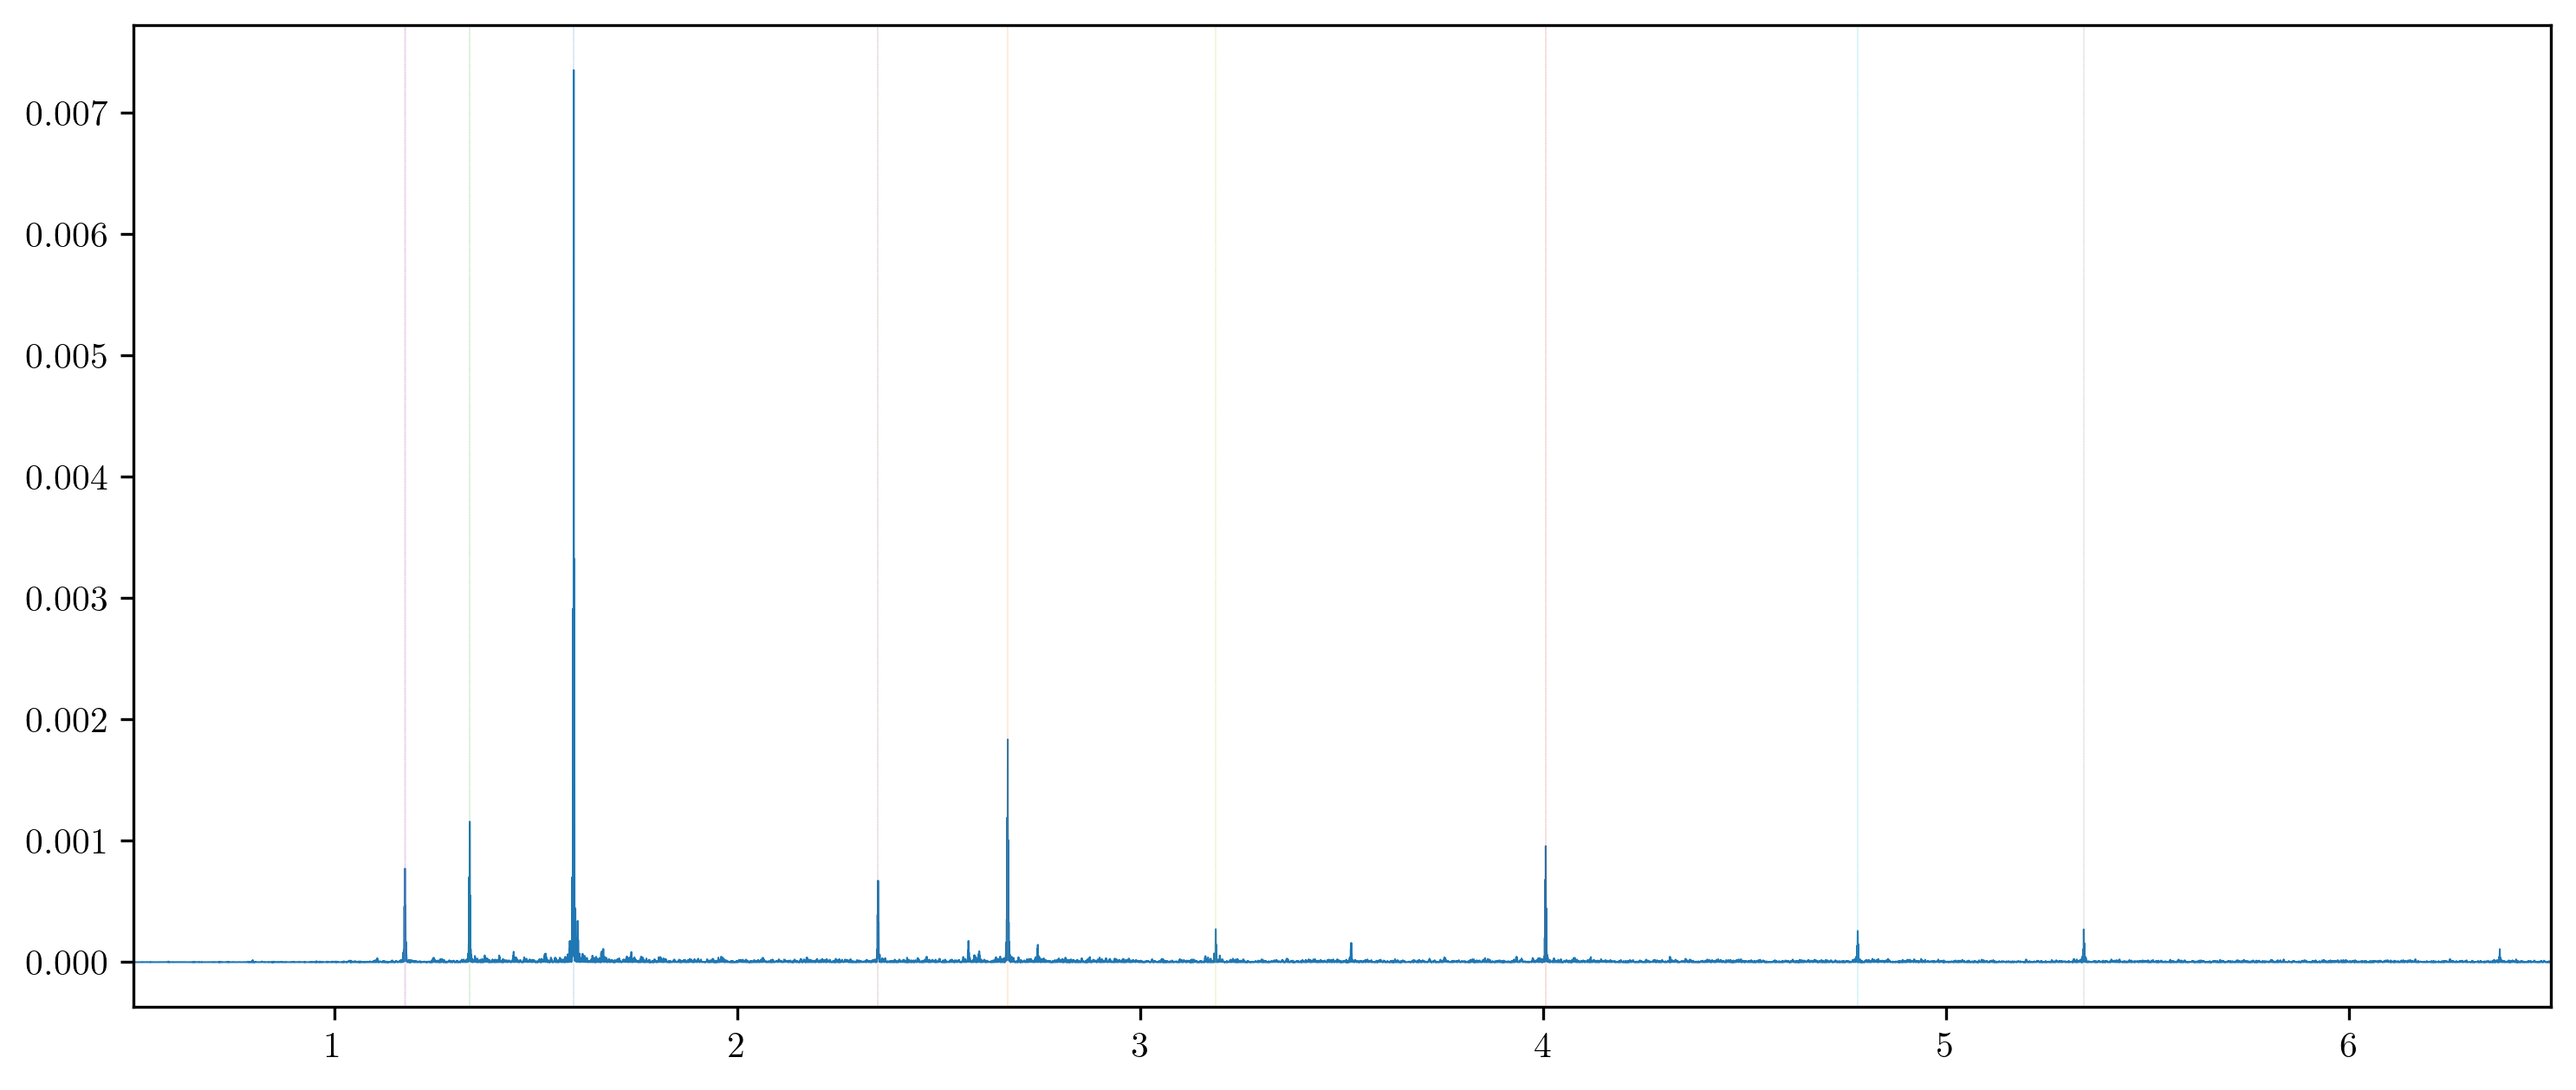

In [16]:
fig = plt.figure(dpi=300, figsize=(12,5))

plt.plot(f_out, p_out, lw=0.5)
for i,f in enumerate(good_fs):
    plt.axvline(f[0],lw=0.1,c=f'C{i}',ls='--',label=f'$f_{i}$')
plt.xlim(0.5,6.5)
len(good_fs[good_fs[:,0]>0.5])

In [20]:
# Step 4: Sample the posterior
with pm.Model() as model_p:
    fs = [pm.Normal(f"f{i}", mu = good_fs[i, 0], sigma=2*good_fs[i,1]) for i in range(good_fs.shape[0])]
    amps = [pm.Normal(f"a{i}", mu = good_amps[i, 0], sigma=2*good_amps[i,1]) for i in range(good_fs.shape[0])]
    phases = [pm.Normal(f"phi{i}", mu = good_phases[i, 0], sigma=2*good_phases[i,1]) for i in range(good_fs.shape[0])]
    
    map_soln_p, logp_p, bic_p = slfv_gp_sin(time.values, flux.values, err.values, fs=fs, amps=amps, phases=phases, model=model_p, return_var=False)
    
    trace = pmx.sample(
        tune=50,
        draws=50,
        initial_accept=0.5,
        start=map_soln_p,
        cores=4,
        chains=4,
        random_seed=42)#,
        #return_inferencedata=True)

optimizing logp for variables: [log_tau, sigma, log_jitter, mean_flux, phi9, phi8, phi7, phi6, phi5, phi4, phi3, phi2, phi1, phi0, a9, a8, a7, a6, a5, a4, a3, a2, a1, a0, f9, f8, f7, f6, f5, f4, f3, f2, f1, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: 2148662.087709927 -> 2178612.1024940973
/Users/carina/anaconda3/lib/python3.7/site-packages/pymc3_ext/sampling/schedule.py:34: UserWarning: there are not enough tuning steps to accomodate the tuning schedule; assigning automatically as 20%/70%/10%
  "there are not enough tuning steps to accomodate the tuning "
/Users/carina/anaconda3/lib/python3.7/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Only 50 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_tau, sigma, log_jitter, mean_flux, phi9, phi8, phi7, phi6, phi5, phi4, phi3, phi2, phi1, phi0, a9, a8, a7, a6, a5, a4, a3, a2, a1, a0, f9, f8, f7

Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 1424 seconds.
/Users/carina/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The acceptance probability does not match the target. It is 0.9999999996407756, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9999999861661663, but should be close to 0.9. Try to increase the number of tuning steps.


In [21]:
map_soln_p

{'f0': array(1.59341991),
 'f1': array(2.67059336),
 'f2': array(1.33527985),
 'f3': array(4.00584486),
 'f4': array(1.17556009),
 'f5': array(2.34874276),
 'f6': array(1.17311484),
 'f7': array(5.34123354),
 'f8': array(3.18678505),
 'f9': array(4.78021246),
 'a0': array(0.00017319),
 'a1': array(6.65491889e-05),
 'a2': array(8.48136641e-05),
 'a3': array(4.58013228e-05),
 'a4': array(5.49360101e-05),
 'a5': array(4.17544732e-05),
 'a6': array(5.35879331e-05),
 'a7': array(2.42606463e-05),
 'a8': array(2.46452532e-05),
 'a9': array(2.42760121e-05),
 'phi0': array(1.67849392),
 'phi1': array(-1.73375654),
 'phi2': array(1.62083607),
 'phi3': array(1.47127233),
 'phi4': array(0.41519238),
 'phi5': array(1.85591261),
 'phi6': array(0.00184871),
 'phi7': array(-1.85417432),
 'phi8': array(-1.56170045),
 'phi9': array(1.86456658),
 'mean_flux': array(1.0000052),
 'log_jitter': array(-8.35246974),
 'sigma_interval__': array(7.7032546),
 'log_tau_interval__': array(-7.46441958),
 'Periodic':

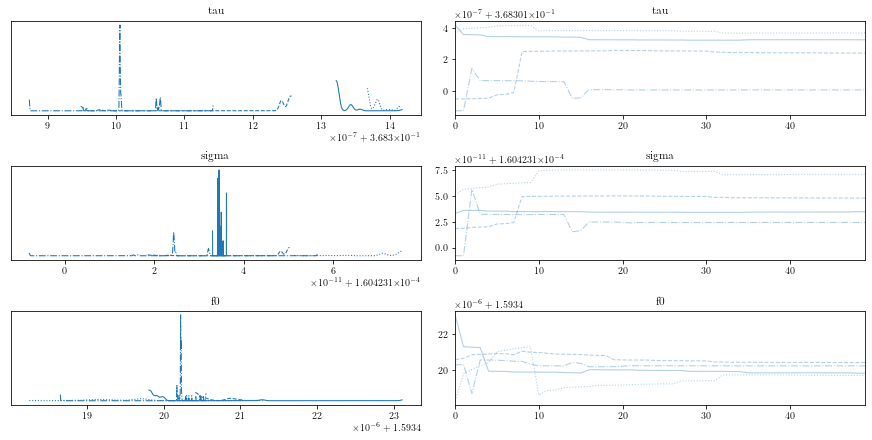

In [22]:
import arviz as az

with model_p:
    _ = az.plot_trace(trace, var_names=['tau','sigma','f0'])

# old: trying to just use a GP kernel per frequency

In [87]:
# Let's try fitting multiple GPs
# Here's a cute function that does that, but the mean can be any number of sinusoids!
def fit_sum_of_GPs(time, flux, err, fs=None, amps=None, model=None, return_var=False, thin=50):
    """
    Use PyMC3 to do a maximum likelihood fit for a whole bunch of GPs
    
    Inputs
    ------
    time : array-like
        Times of observations
    flux : array-like
        Observed fluxes
    err : array-like
        Observational uncertainties    
    fs : array-like, elements are PyMC3 distributions
        Array with frequencies to fit, default None (i.e., only the GP is fit)
    amps : array-like, elements are PyMC3 distributions
        Array with amplitudes to fit, default None (i.e., only the GP is fit)
    model : `pymc3.model.Model`
        PyMC3 Model object, will fail unless given
    return_var : bool, default True
        If True, returns the variance of the GP
    thin : integer, default 50
        Calculate the variance of the GP every `thin` points.
        
    Returns
    -------
    map_soln : dict
        Contains best-fit parameters and the gp predictions
    logp : float
        The log-likelihood of the model
    bic : float
        The Bayesian Information Criterion, -2 ln P + m ln N
    var : float
        If `return_var` is True, returns the variance of the GP
    """
    
    assert model is not None, "Must provide a PyMC3 model object"
    
    # define the pseudo Nyquist frequency
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    
    rayleigh = 1.0 / (time.max() - time.min())
    
    ls = LombScargle(time, flux, dy=err, normalization='psd')
    freq, power = ls.autopower(maximum_frequency=pseudo_NF)
    
    mean = pm.Normal("mean", mu = 1.0, sigma=np.std(flux))

    # A jitter term describing excess white noise; the lightcurve is pretty good,
    # with few-to-no sector-to-sector systematics. We'll return to this point 
    # later but for now I'm using we can use a single Jitter term.
    log_jitter = pm.Normal("log_jitter", mu=np.log(err.mean()), sigma=5.0)

    # A term to describe the non-periodic variability
    # sigma is the standard deviation, which I'm gonna guess is somewhere 
    # around the overall standard deviation of the lightcurve, plus or minus 20 
    # percent. Meanwhile, tau roughly corresponds to the breakoff in the power
    # spectrum, which occurs around 0.1 to 10 d^-1 (0.1 - 10 d periods). rho 
    # and tau are related by a factor of pi/Q (the quality factor, which we
    # hold fixed at 1/sqrt(2)
    sigma_guess = slfv_ex['alpha'].iloc[0] ** 2.0
    log_sigma = pm.Uniform("log_sigma", lower=np.log(sigma_guess)-2, upper=np.log(sigma_guess)+2)
    sigma0 = pm.Deterministic("sigma_0", tt.exp(log_sigma))

    logtau = pm.Uniform("log_tau", lower=-1, upper=1)
    tau0 = pm.Deterministic("tau_0", tt.exp(logtau))
    
    Q0 = pm.Uniform("Q",lower=0.0,upper=1/np.sqrt(2.0)+0.00001, testval=1/np.sqrt(2.0)) #simplify our equation here with no periodic component.
    rho0 = pm.Deterministic("rho_0", tau0 * np.pi / Q0)

    kernel = terms.SHOTerm(sigma=sigma0, rho=rho0, tau=tau0)
    
    if fs is not None:
        for i,(f,a) in enumerate(zip(fs,amps)):
            #angular frequency is 2pif
            f = pm.Uniform(f'f{i}', lower=f-10*rayleigh, upper=f+10*rayleigh)
            w = pm.Deterministic(f'w{i}', 2*np.pi*f)
            logQ = pm.Uniform(f'log_Q{i}', lower=np.log(1/np.sqrt(2.0)), upper=15.0, testval=np.log(10000))
            Q = pm.Deterministic(f'Q{i}', tt.exp(logQ))
            #at w0, PSD is sqrt(2/pi)*S0 Q^2, so amplitude is sqrt of that
            logS0 = pm.Uniform(f'log_S{i}', lower=-15.0, upper=15.0, testval=np.log(power.mean()))
            S0 = pm.Deterministic(f'S{i}', tt.exp(logS0))
            kernel += terms.SHOTerm(w0=w,Q=Q,S0=S0)
        

    gp = GaussianProcess(
        kernel,
        t=time,
        diag=err ** 2.0 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )


    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=flux)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(flux))
    
    # Also compute the power spectrum
    pm.Deterministic('PSD', gp.kernel.get_psd(2.0*np.pi*freq))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()
    logp = model.logp(map_soln)
    # parameters are tau, sigma, Q/rho, mean, jitter, plus 3 per frequency (w0, Q, S)
    if fs is not None:
        n_par = 5.0 + (3.0 * len(fs))
    else:
        n_par = 5.0
    bic = -2.0*logp + n_par * np.log(len(time))
    
    #compute variance as well...
    if return_var:
        eval_in_model(gp.compute(time[::thin],yerr=err[::thin]), map_soln)
        mu, var = eval_in_model(gp.predict(flux[::thin], t=time[::thin], return_var=True), map_soln)
        return map_soln, logp, bic, var
        
    return map_soln, logp, bic

In [88]:
# Let's just keep adding components on until we hit the minimum BIC!
maps = []
bics = []
old_bic = np.inf
for nf in range(good_fs.shape[0]+1):
    with pm.Model() as model:
        if nf == 0:
            map_soln, logp, bic = fit_sum_of_GPs(time.values, flux.values, err.values, model=model)
        else:
            fs = good_fs[:nf,0]
            amps = good_amps[:nf,0]
            map_soln, logp, bic = fit_sum_of_GPs(time.values, flux.values, err.values, fs=fs, amps=amps, model=model)
    maps.append(map_soln)
    bics.append(bic)

optimizing logp for variables: [Q, log_tau, log_sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2143576.1941383174 -> 2178099.014511865
optimizing logp for variables: [log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1468809.4336651699 -> 2173705.916960531
optimizing logp for variables: [log_S1, log_Q1, f1, log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1088561.7250819022 -> 2165108.667348456
optimizing logp for variables: [log_S2, log_Q2, f2, log_S1, log_Q1, f1, log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1077934.8887702033 -> 2164434.76053303
optimizing logp for variables: [log_S3, log_Q3, f3, log_S2, log_Q2, f2, log_S1, log_Q1, f1, log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1071758.0499257932 -> 2164007.723085363
optimizing logp for variables: [log_S4, log_Q4, f4, log_S3, log_Q3, f3, log_S2, log_Q2, f2, log_S1, log_Q1, f1, log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: NaN result encountered.
logp: 1066014.5721837434 -> 1066014.5721837434
optimizing logp for variables: [log_S5, log_Q5, f5, log_S4, log_Q4, f4, log_S3, log_Q3, f3, log_S2, log_Q2, f2, log_S1, log_Q1, f1, log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 445695.7358971895 -> 445695.7358971895
optimizing logp for variables: [log_S6, log_Q6, f6, log_S5, log_Q5, f5, log_S4, log_Q4, f4, log_S3, log_Q3, f3, log_S2, log_Q2, f2, log_S1, log_Q1, f1, log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 439677.9011989727 -> 439677.9011989727
optimizing logp for variables: [log_S7, log_Q7, f7, log_S6, log_Q6, f6, log_S5, log_Q5, f5, log_S4, log_Q4, f4, log_S3, log_Q3, f3, log_S2, log_Q2, f2, log_S1, log_Q1, f1, log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 434636.2142307661 -> 434636.2142307661
optimizing logp for variables: [log_S8, log_Q8, f8, log_S7, log_Q7, f7, log_S6, log_Q6, f6, log_S5, log_Q5, f5, log_S4, log_Q4, f4, log_S3, log_Q3, f3, log_S2, log_Q2, f2, log_S1, log_Q1, f1, log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: NaN result encountered.
logp: 429250.0626515016 -> 429250.0626515016
optimizing logp for variables: [log_S9, log_Q9, f9, log_S8, log_Q8, f8, log_S7, log_Q7, f7, log_S6, log_Q6, f6, log_S5, log_Q5, f5, log_S4, log_Q4, f4, log_S3, log_Q3, f3, log_S2, log_Q2, f2, log_S1, log_Q1, f1, log_S0, log_Q0, f0, Q, log_tau, log_sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 428777.98744197923 -> 428777.98744197923


In [90]:
maps[0]

{'mean': array(1.00001149),
 'log_jitter': array(-8.40703098),
 'log_sigma_interval__': array(7.37176924),
 'log_tau_interval__': array(-8.0811521),
 'Q_interval__': array(6.92235523),
 'log_sigma': array(-7.14537328),
 'sigma_0': array(0.0007885),
 'log_tau': array(-0.99938156),
 'tau_0': array(0.36810702),
 'Q': array(0.7064206),
 'rho_0': array(1.63704501),
 'pred': array([1.00126897, 1.00126595, 1.00126287, ..., 0.99980587, 0.99979825,
        0.9997907 ]),
 'PSD': array([1.82963765e-07, 1.82963765e-07, 1.82963765e-07, ...,
        2.54325898e-17, 2.54324824e-17, 2.54323750e-17])}

In [77]:
kernel = terms.SHOTerm(S0=np.exp(-8),Q=1000,w0=2*np.pi*1.3)
psd = kernel.get_psd(2*np.pi*freq).eval()

In [95]:
GaussianProcess.marginal()

NameError: name 'gp' is not defined

([<matplotlib.lines.Line2D at 0x7fca04c33690>],
 {'mean': array(1.),
  'log_jitter': array(-7.22938442),
  'log_sigma_interval__': array(0.),
  'log_tau_interval__': array(0.),
  'Q_interval__': array(11.16635187),
  'f0_interval__': array(0.),
  'log_Q0_interval__': array(0.50119136),
  'log_S0_interval__': array(0.06417722),
  'f1_interval__': array(0.),
  'log_Q1_interval__': array(0.50119136),
  'log_S1_interval__': array(0.06417722),
  'f2_interval__': array(0.),
  'log_Q2_interval__': array(0.50119136),
  'log_S2_interval__': array(0.06417722),
  'f3_interval__': array(0.),
  'log_Q3_interval__': array(0.50119136),
  'log_S3_interval__': array(0.06417722),
  'f4_interval__': array(0.),
  'log_Q4_interval__': array(0.50119136),
  'log_S4_interval__': array(0.06417722),
  'f5_interval__': array(0.),
  'log_Q5_interval__': array(0.50119136),
  'log_S5_interval__': array(0.06417722),
  'f6_interval__': array(0.),
  'log_Q6_interval__': array(0.50119136),
  'log_S6_interval__': array(

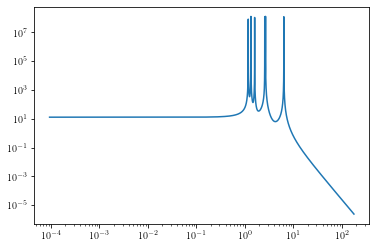

In [93]:
plt.loglog(freq,maps[-1]['PSD']),maps[-1]

In [80]:
np.log(1000),np.log(50)

(6.907755278982137, 3.912023005428146)